In [1]:
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd 
from copy import copy

plt.rcParams["font.family"] = "Arial"
data = pd.read_excel("data_all.xlsx")

In [2]:
data_all = [] 
for batch_num in range(19):
    start_index = (data[data["ton"].isna()].index)[2*batch_num]
    end_index = (data[data["ton"].isna()].index)[2*batch_num + 1]
    print(data.iloc[start_index : end_index])
    data_all.append(
        data.iloc[start_index + 1 : end_index]
    )

print(data.iloc[(data[data["ton"].isna()].index)[-1]::])

data_all.append(
    data.iloc[(data[data["ton"].isna()].index)[-1] + 1::]
)
data_all_origin = copy(data_all)
data_all = pd.concat(data_all)

                       exp      对位选择性      间位选择性      邻位选择性     ton
0                    第一轮随机        NaN        NaN        NaN     NaN
1    1-I,F,Y,G,K,V,A,N,M,D  20.475293  33.274272  46.250436   6.969
2    2-L,V,Q,Y,K,N,C,F,P,E  21.367940  31.454554  47.177505   4.455
3    3-N,E,I,G,K,Y,I,V,N,Y  21.722533  32.787287  45.490180   2.721
4    4-D,E,T,I,K,I,Q,Y,A,M  20.138117  32.318466  47.543417  12.690
5    5-N,Q,I,Q,K,P,Y,V,D,Y  21.499640  30.798048  47.702312   4.267
6    6-N,F,M,A,K,P,N,E,N,Y  21.985530  32.472445  45.542025   2.786
7    7-T,Y,N,Q,K,E,T,G,T,D  20.543606  32.453409  47.002985   6.467
8    8-T,D,V,D,K,F,S,N,Y,D  20.275215  32.514524  47.210261   8.847
9    9-N,V,E,E,K,T,P,T,Y,Y  20.835778  34.293726  44.870497   3.043
10  10-F,F,Y,T,K,D,S,N,Y,D  20.383785  32.835797  46.780418   8.795
11  11-P,V,H,C,K,S,D,I,E,S  20.632699  30.269221  49.098080  14.448
12  12-N,Q,F,L,K,H,D,C,D,G  21.624776  28.465120  49.910105  10.828
13  13-P,P,N,C,K,H,M,C,C,V  20.841029  29.374709

In [3]:
import re
sequences = np.array([re.search(r'(?:^\d+-)?(?P<seq>(?:[A-Z],?)+)(?:-\d+)?$', text).group("seq").split(',') for text in data_all["exp"].values])
tons = data_all["ton"].values
ton1 = data_all["ton"].values*data_all["对位选择性"].values
ton2 = data_all["ton"].values*data_all["间位选择性"].values
ton3 = data_all["ton"].values*data_all["邻位选择性"].values

# Sort indices based on ton values
sorted_indices = np.argsort(tons)[::-1]

# Sort sequences and ton
sorted_sequences = sequences[sorted_indices]
sorted_tons = tons[sorted_indices]
sorted_ton1 = ton1[sorted_indices]
sorted_ton2 = ton2[sorted_indices]
sorted_ton3 = ton3[sorted_indices]

234
r = 0.43
209
r = 0.35
210
r = 0.28


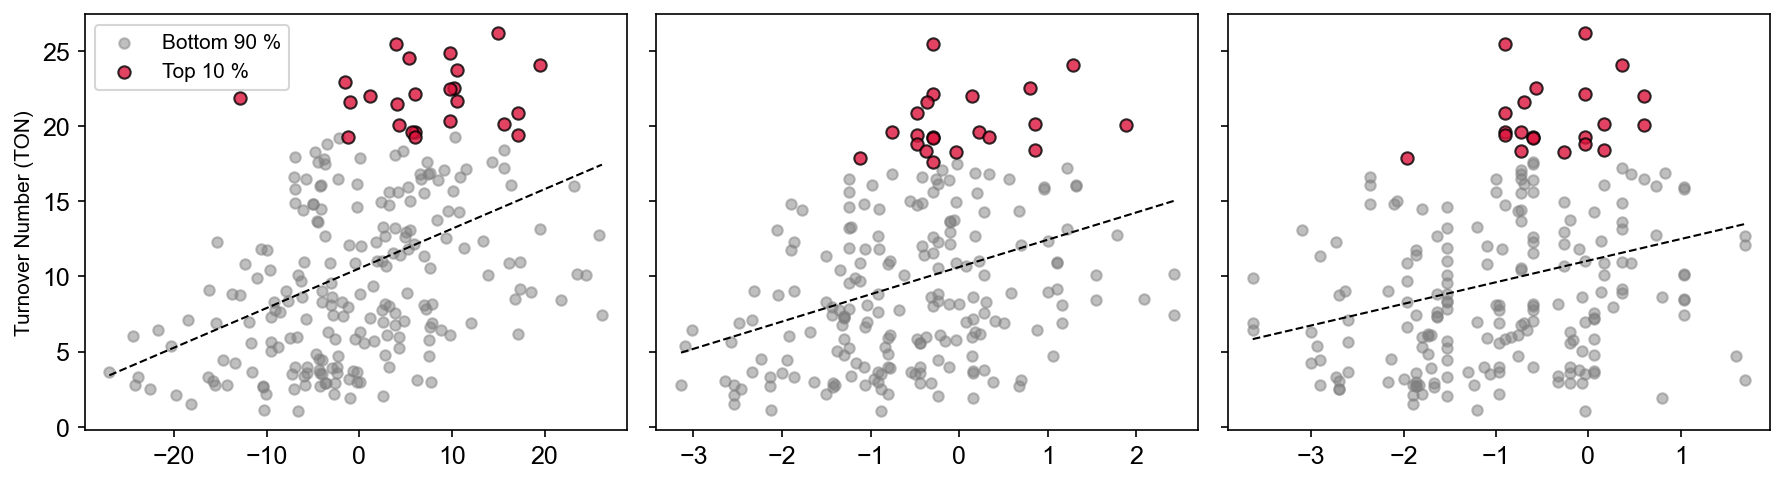

In [4]:
sorted_sequences_original = sorted_sequences
sorted_tons_original = sorted_tons

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# ------------------------------------------------------------------
#  Kyte–Doolittle lookup table
KD = {  'I': 4.5,'V': 4.2,'L': 3.8,'F': 2.8,'C': 2.5,'M': 1.9,'A': 1.8,
        'G': -0.4,'T': -0.7,'S': -0.8,'W': -0.9,'Y': -1.3,'P': -1.6,
        'H': -3.2,'E': -3.5,'Q': -3.5,'D': -3.5,'N': -3.5,'K': -3.9,
        'R': -4.5
    }

def to_string(seq):
    """Coerce numpy‐array or string to upper-case string."""
    return "".join(seq.astype(str)) if not isinstance(seq, str) else seq.upper()

def kd_global(seq):                         # whole peptide, sum
    s = to_string(seq)
    return sum(KD[aa] for aa in s)

def kd_window(seq, half_width):
    """Mean KD over window centred on unique K. half_width=1 → K±1 (3-mer)."""
    s = to_string(seq)
    k_idx = [i for i, aa in enumerate(s) if aa == "K"]
    if len(k_idx) != 1:
        return np.nan          # skip multi-K peptides
    k = k_idx[0]
    L = len(s)
    if k < half_width or k > L - half_width - 1:
        return np.nan          # K too close to edge
    window = s[k-half_width:k+half_width+1]   # slice
    return np.mean([KD[aa] for aa in window])

# ------------------------------------------------------------------
#  Pre-compute hydrophobicity scores
global_kd = np.array([kd_global(s)             for s in sorted_sequences_original])
kd_3mer   = np.array([kd_window(s, 1)          for s in sorted_sequences_original])
kd_5mer   = np.array([kd_window(s, 2)          for s in sorted_sequences_original])
tons      = np.array(sorted_tons_original)

datasets = [
    ("Global KD (sum)",         global_kd),
    ("Mean KD of [K-2, K+2] window",  kd_5mer),
    ("Mean KD of [K-1, K+1] window",  kd_3mer),
]

# ------------------------------------------------------------------
#  Draw 1×3 grid
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), dpi=150, sharey=True)

for ax, (label, kd_vals) in zip(axes, datasets):
    mask   = ~np.isnan(kd_vals)
    kd_sub = kd_vals[mask]
    ton_sub = tons[mask]

    print(len(ton_sub))
    cutoff = np.percentile(ton_sub, 90)
    is_top = ton_sub >= cutoff

    ax.scatter(kd_sub[~is_top], ton_sub[~is_top],
               color="gray", alpha=0.5, s=25, label="Bottom 90 %")
    ax.scatter(kd_sub[is_top],  ton_sub[is_top],
               color="crimson", edgecolor="k", alpha=0.8, s=35, label="Top 10 %")

    # trend-line
    m, b = np.polyfit(kd_sub, ton_sub, 1)
    xfit = np.linspace(kd_sub.min(), kd_sub.max(), 100)
    ax.plot(xfit, m*xfit + b, 'k--', lw=1)

    r, p = pearsonr(kd_sub, ton_sub)
    # ax.set_xlabel(label, fontsize=10)
    # ax.set_title(f"r = {r:.2f}", fontsize=10)
    ax.tick_params(labelsize=12)
    print(f"r = {r:.2f}")

axes[0].set_ylabel("Turnover Number (TON)", fontsize=10)
axes[0].legend(loc="upper left")
# fig.suptitle("Hydrophobicity vs TON (global and local windows)", fontsize=12)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# save &/or show
plt.show()

In [5]:
kd_global(np.array([i for i in "MVMWKGIFCI"]))

17.1

Global KD (sum): n=234, r=0.43, p=0.000
Mean KD of [K-2, K+2] window: n=209, r=0.35, p=0.000
Mean KD of [K-1, K+1] window: n=210, r=0.28, p=0.000


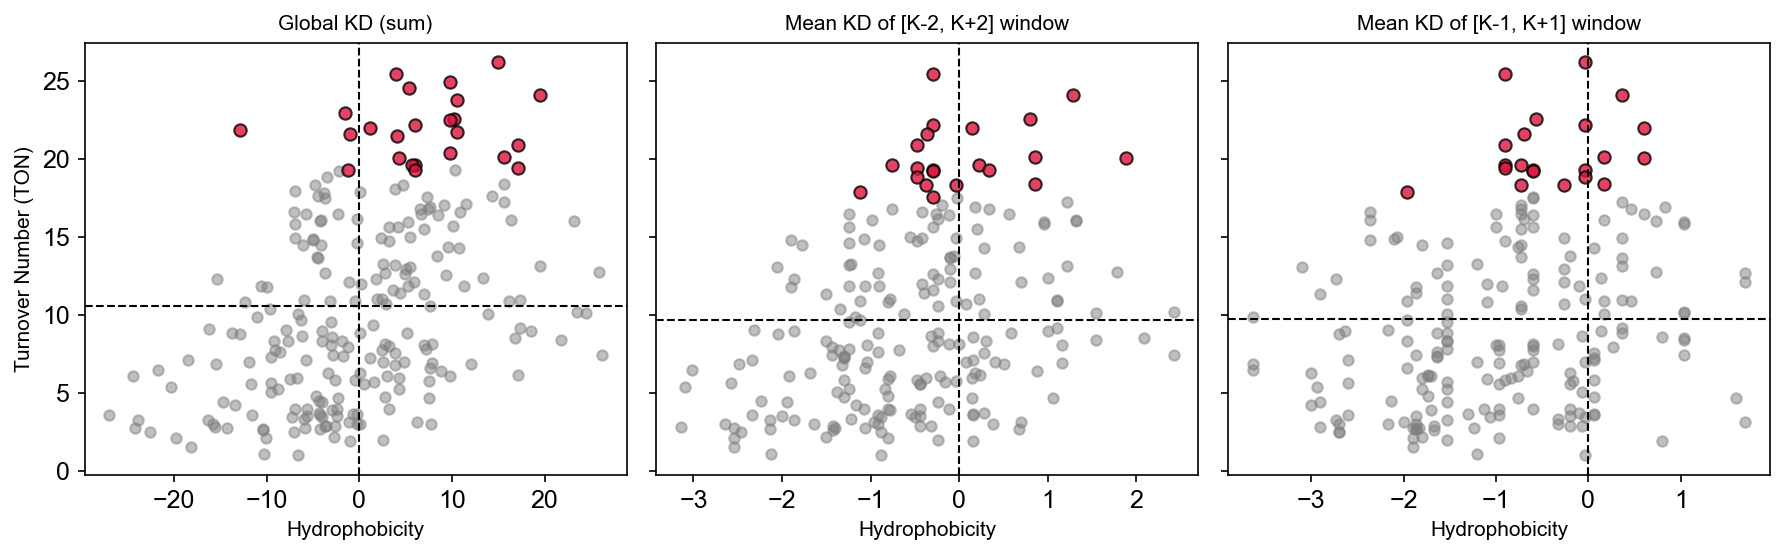

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# … assume sorted_sequences_original and sorted_tons_original are defined …

# Pre-compute hydrophobicity scores as before…
# global_kd, kd_5mer, kd_3mer, tons, datasets …

# Draw 1×3 grid
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

for ax, (label, kd_vals) in zip(axes, datasets):
    # Mask out any nan windows
    mask    = ~np.isnan(kd_vals)
    kd_sub  = kd_vals[mask]
    ton_sub = tons[mask]

    # Determine top‐10% for coloring
    cutoff = np.percentile(ton_sub, 90)
    is_top = ton_sub >= cutoff

    # Scatter bottom 90%
    ax.scatter(
        kd_sub[~is_top],
        ton_sub[~is_top],
        color="gray",
        alpha=0.5,
        s=25,
        label="Bottom 90 %"
    )
    # Scatter top 10%
    ax.scatter(
        kd_sub[is_top],
        ton_sub[is_top],
        color="crimson",
        edgecolor="k",
        alpha=0.8,
        s=35,
        label="Top 10 %"
    )

    # Draw horizontal line at the mean TON
    mean_ton = ton_sub.mean()
    ax.axhline(
        y=mean_ton,
        color="black",
        linestyle="--",
        linewidth=1,
        label=f"Mean TON ({mean_ton:.1f})"
    )

    # Draw vertical zero line at KD = 0
    ax.axvline(
        x=0,
        color="black",
        linestyle="--",
        linewidth=1,
        label="KD = 0"
    )

    # Compute and print Pearson r if you still want it
    r, p = pearsonr(kd_sub, ton_sub)
    print(f"{label}: n={len(ton_sub)}, r={r:.2f}, p={p:.3f}")

    ax.set_title(label, fontsize=10)
    ax.tick_params(labelsize=12)
    ax.set_xlabel("Hydrophobicity", fontsize=10)

# Common Y label
axes[0].set_ylabel("Turnover Number (TON)", fontsize=10)

# # Only one legend per subplot; avoid duplicate labels
# for ax in axes:
#     ax.legend(loc="upper right", fontsize=8)

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22124\535156797.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


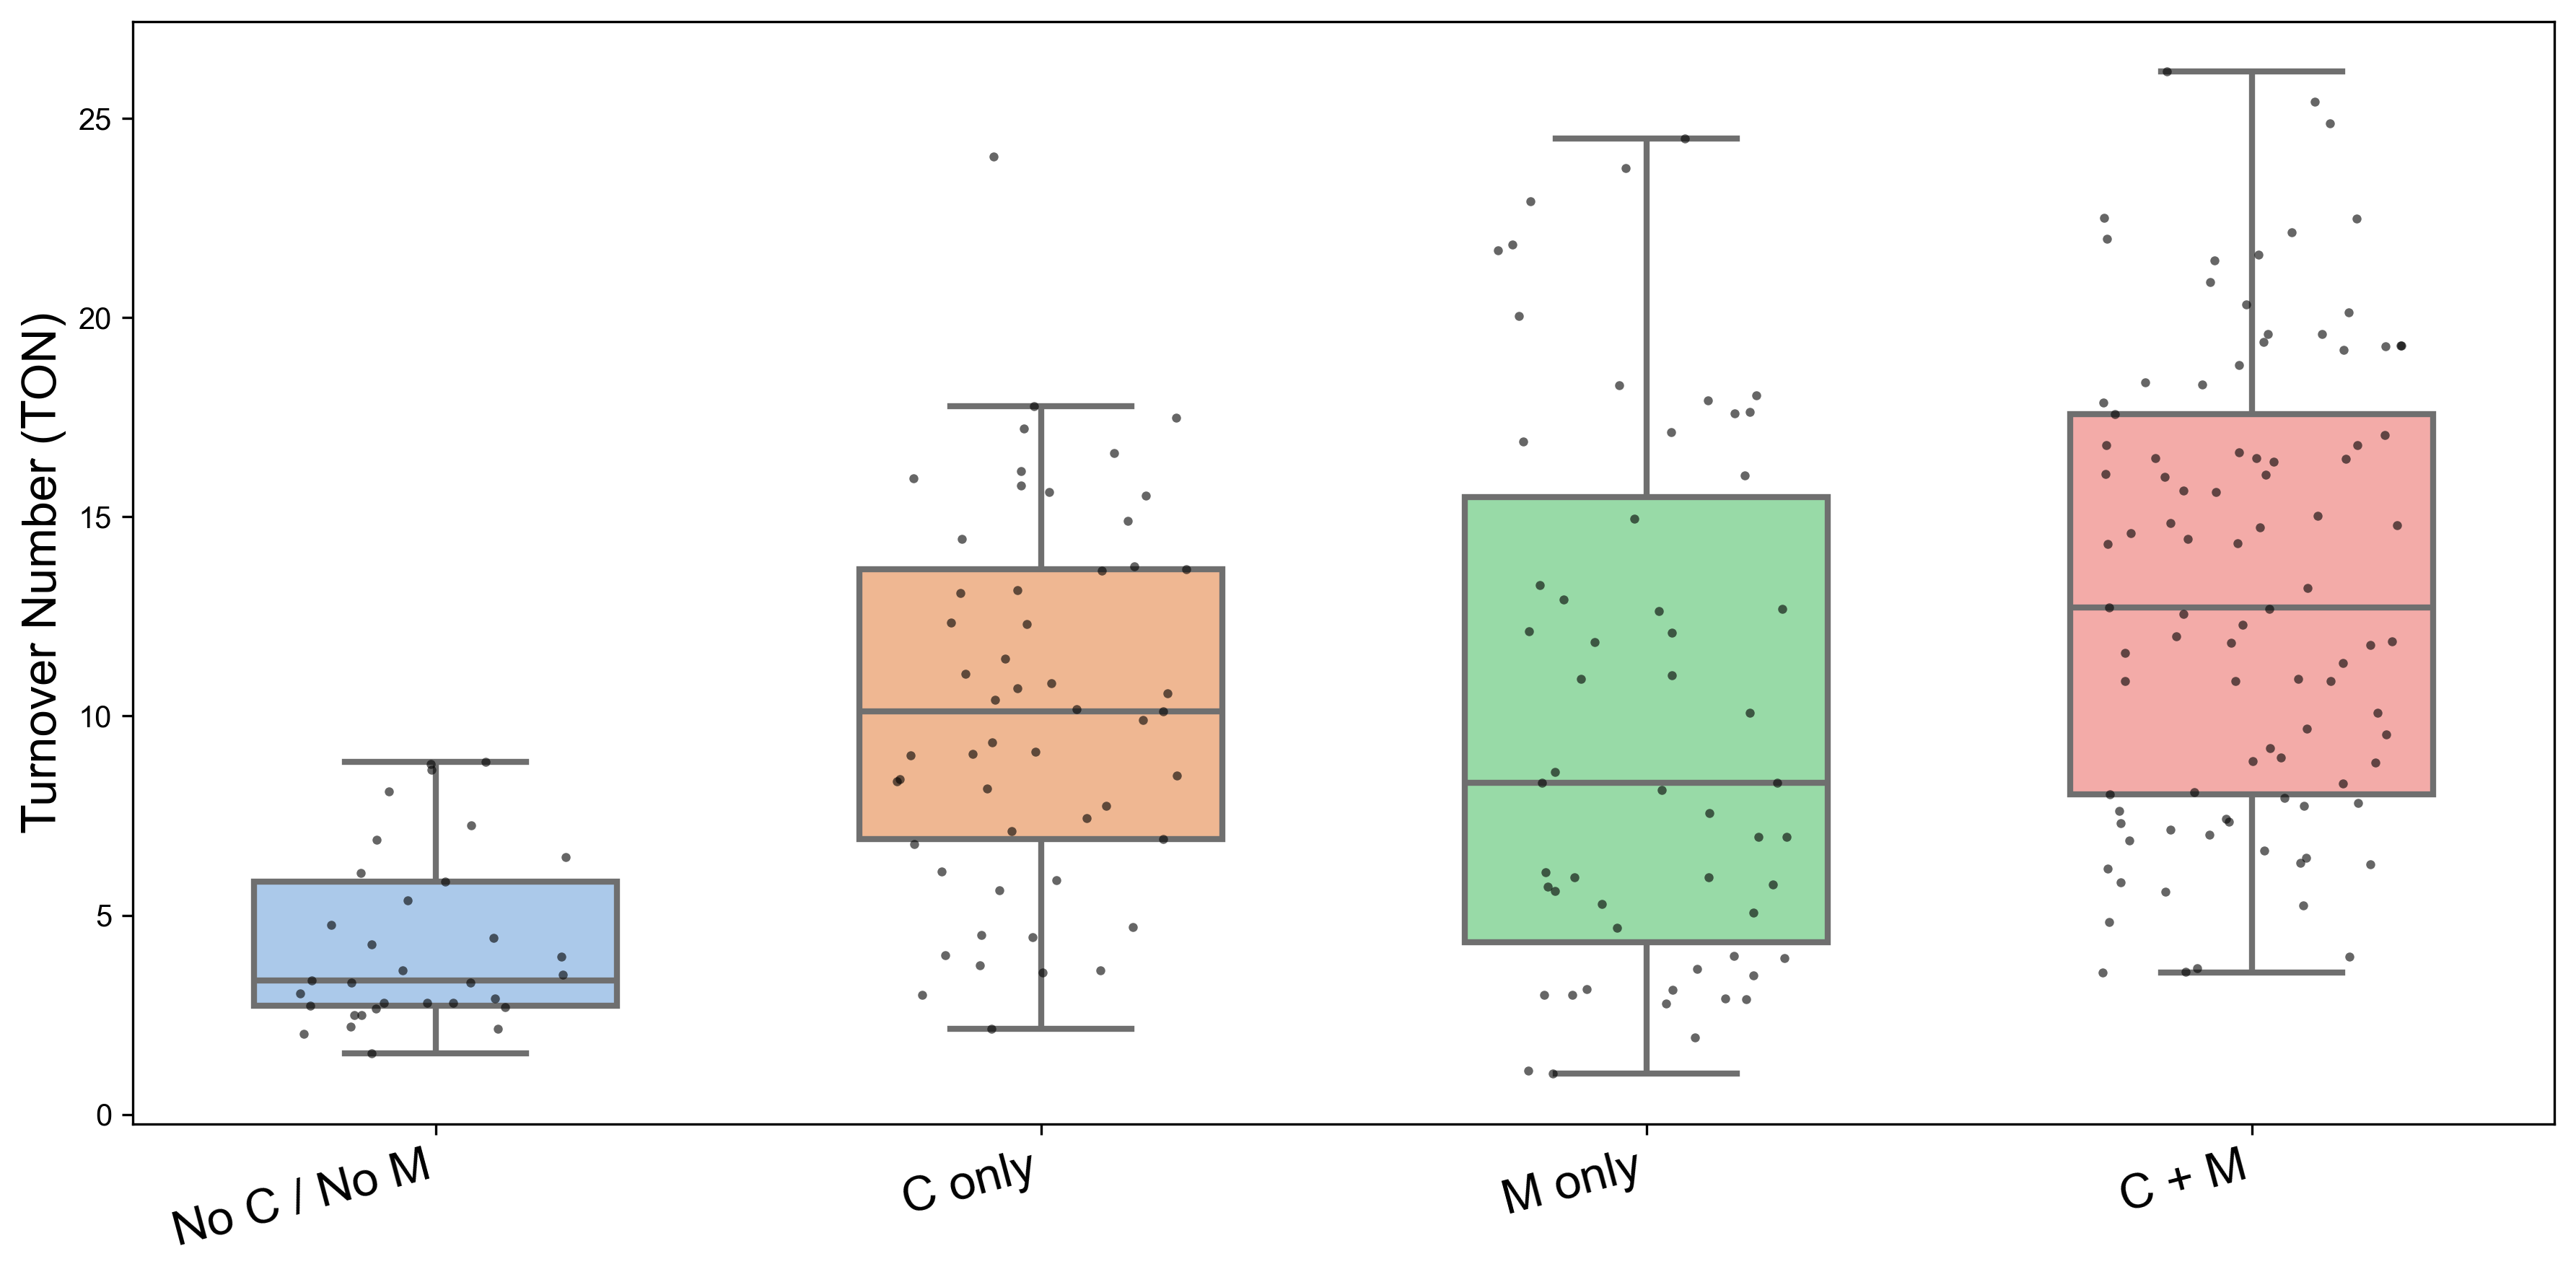

Average TON by group:
Group
No C / No M     4.31
C only         10.30
M only         10.07
C + M          13.29



In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --- Assume you already have these two lists in memory ---------------
# sorted_sequences : list[str]  # peptide strings, e.g. "MCMKLCIIMT"
# sorted_tons      : list[float]  # corresponding TONs
# --------------------------------------------------------------------

# Build a tidy DataFrame with a column for the group label
records = []
for seq, ton in zip(sorted_sequences, sorted_tons):
    has_c = 'C' in seq
    has_m = 'M' in seq

    if not has_c and not has_m:
        group = "No C / No M"
    elif has_c and not has_m:
        group = "C only"
    elif has_m and not has_c:
        group = "M only"
    else:
        group = "C + M"
    records.append({"Group": group, "TON": ton})

df = pd.DataFrame(records)

# Choose the order in which the boxes will appear
order = ["No C / No M", "C only", "M only", "C + M"]

plt.figure(figsize=(12, 6), dpi=300)

ax = sns.boxplot(
    data=df, x="Group", y="TON",
    order=order, linewidth=2, width=0.6,
    palette="pastel",
    showfliers=False)          # optional: drop box-plot outliers

sns.stripplot(
    data=df, x="Group", y="TON",
    order=order, color="k", size=3,
    jitter=0.25, alpha=0.6,
    legend=False)                #  ← prevent that ♦ from being created

# If you forget legend=False, just run:
# ax.get_legend().remove()

plt.ylabel("Turnover Number (TON)", fontsize = 16)
plt.xlabel("")
plt.xticks(rotation=15, ha="right", fontsize = 16)
plt.tight_layout()
plt.show()

# --- average TON for each C/M category --------------------------------
avg_ton = df.groupby("Group")["TON"].mean().reindex(order)  # keep custom order
print("Average TON by group:")
print(avg_ton.round(2).to_string())
print()

#### Go and check how the existence of amino acids will influence the TON 

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22124\1226986997.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', n_labels)


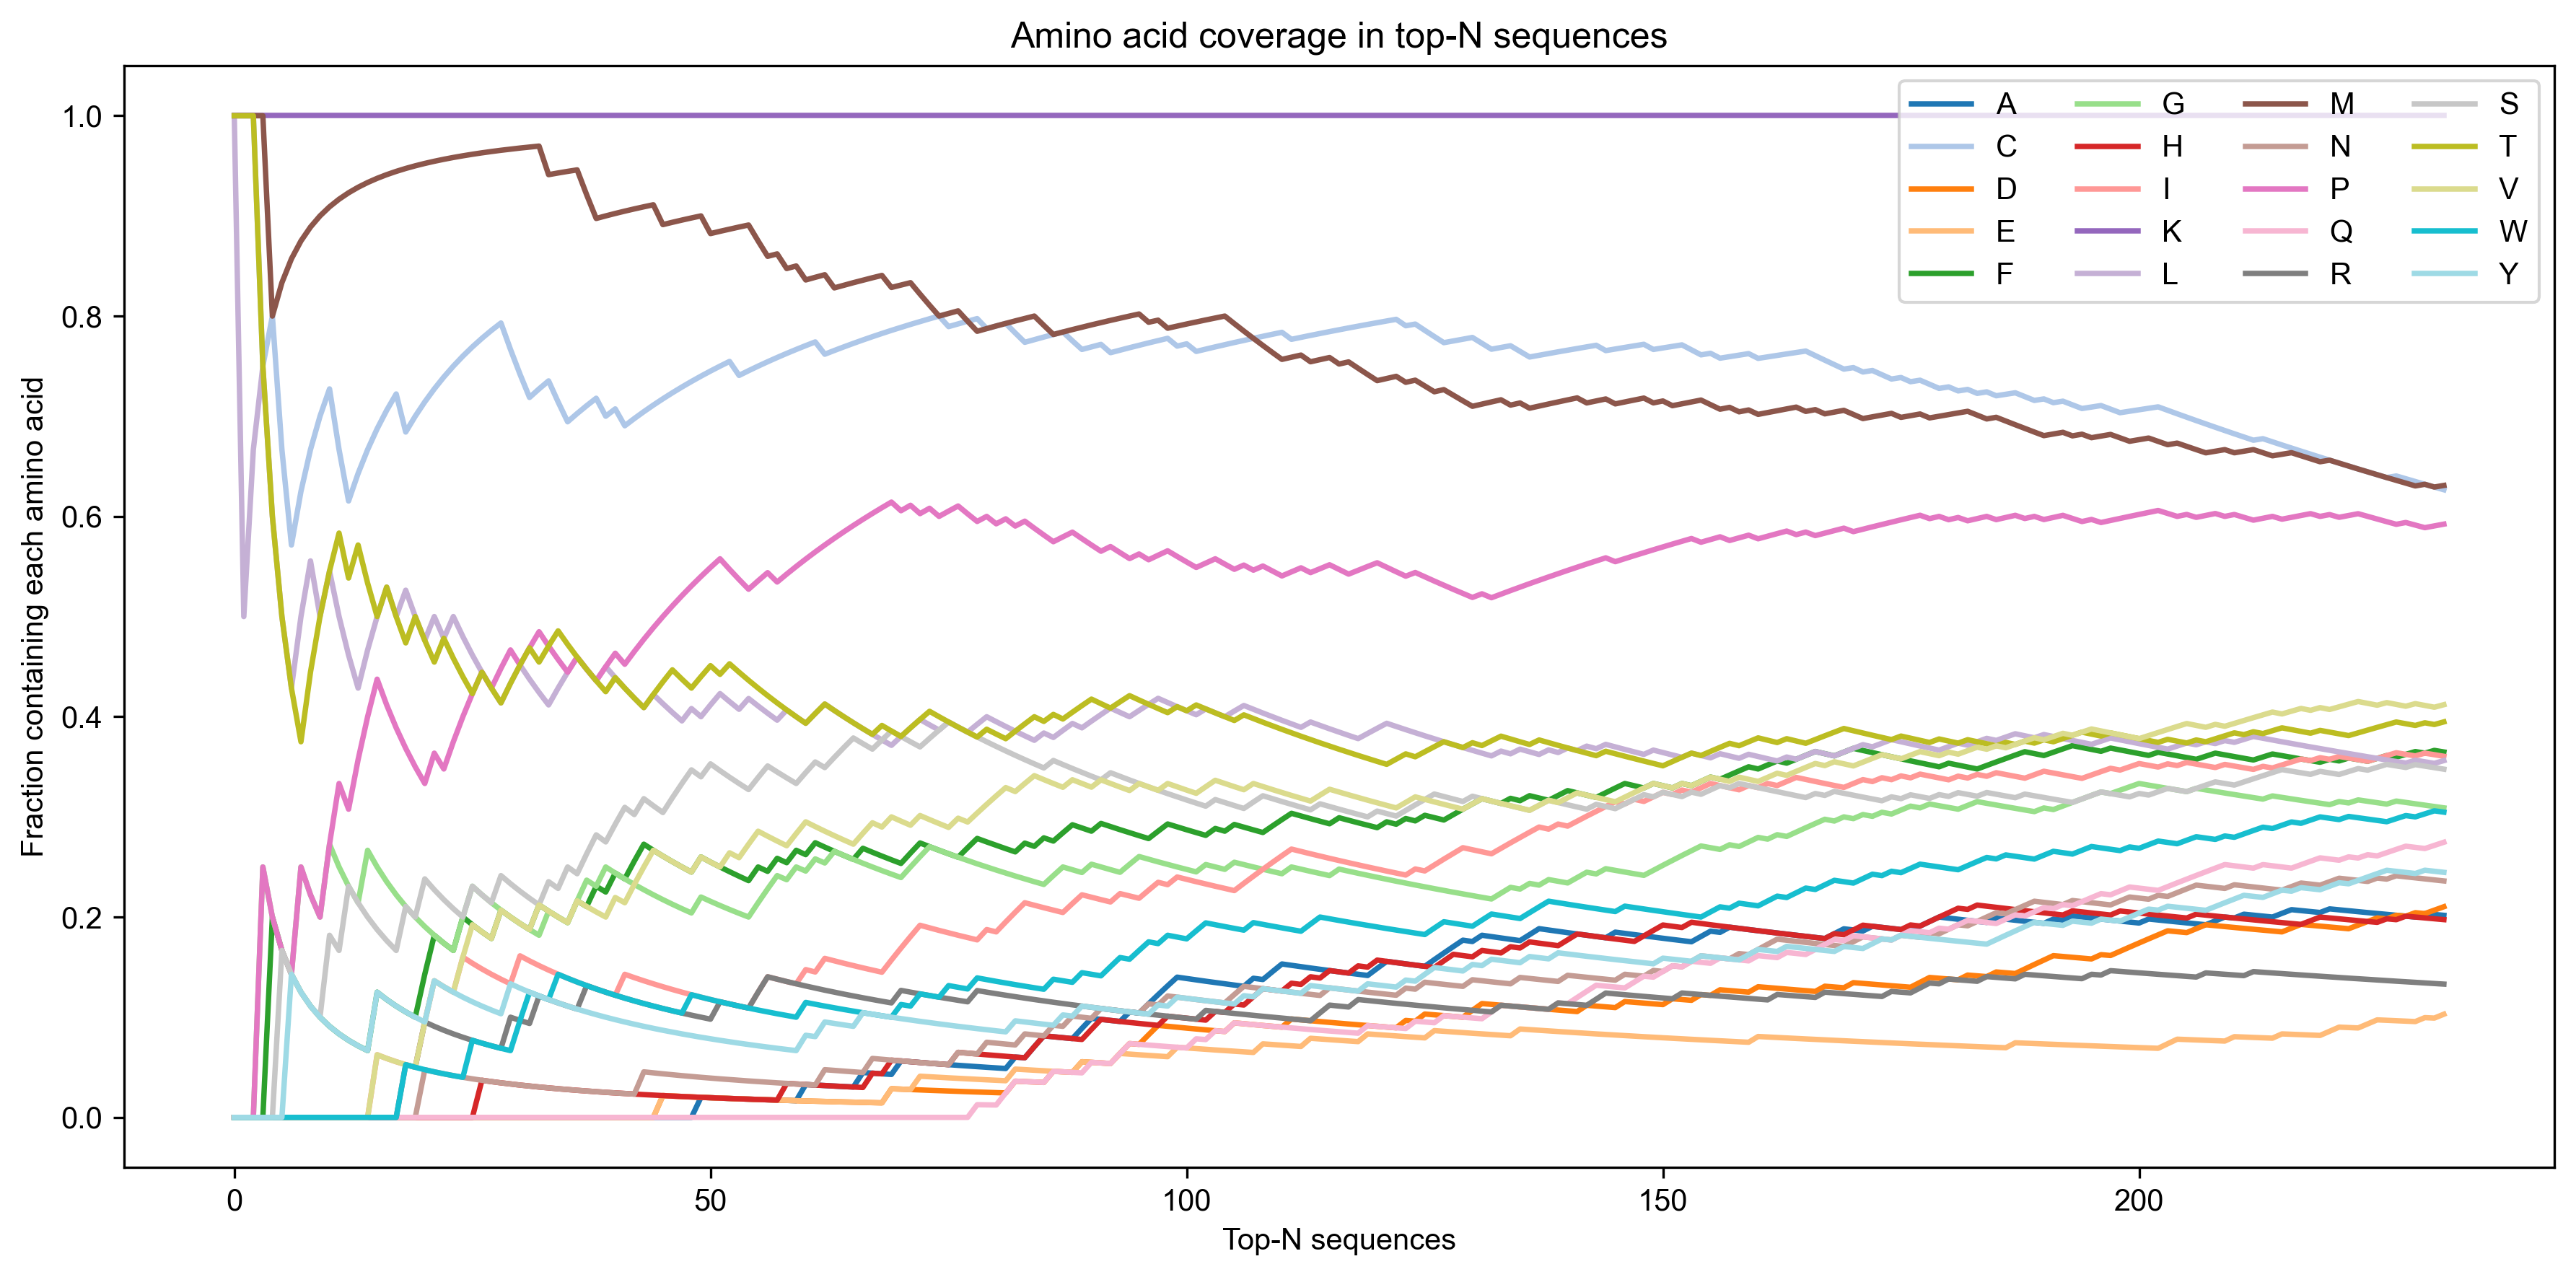

In [8]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Assume `sequences` and `sorted_sequences` are already defined
labels = np.unique(sequences)
n_labels = len(labels)

# Use distinct colormap and marker cycle
cmap = cm.get_cmap('tab20', n_labels)
marker_styles = ['o', 's', '^', 'v', 'D', '*', 'P', 'X', '<', '>', 'h', 'H', '+', 'x', 'd', '|', '_']

plt.figure(figsize=(12, 6), dpi = 300)

for idx, label_temp in enumerate(labels):
    y_values = [((sorted_sequences[0:i] == label_temp).sum(axis=1) > 0).sum() / i for i in range(1, len(sorted_sequences))]
    plt.plot(
        y_values,
        label=label_temp,
        color=cmap(idx),
        linestyle='-',  # or '--', etc., if further distinction is needed
        linewidth=1.8
    )

# plt.xlim(0, 20)
plt.legend(ncol=4)  # adjust number of columns in legend if needed
plt.xlabel("Top-N sequences")
plt.ylabel("Fraction containing each amino acid")
plt.title("Amino acid coverage in top-N sequences")
plt.tight_layout()
plt.show()

In [9]:
sorted_tons[(sorted_sequences == label_temp).any(axis = 1)].mean()

7.333275862068965

In [10]:
# import matplotlib.pyplot as plt
# from scipy.stats import ttest_ind

# # Ensure sorted_sequences and sorted_tons are defined before this block

# means = []
# stds = []
# ton_values_num = []
# p_values = []
# effect_directions = []

# labels = np.unique(sorted_sequences)

# for label_temp in labels:
#     mask = (sorted_sequences == label_temp).any(axis=1)
#     ton_with = sorted_tons[mask]
#     ton_without = sorted_tons[~mask]
    
#     mean_with = ton_with.mean()
#     mean_without = ton_without.mean()
    
#     means.append(mean_with)
#     stds.append(ton_with.std())
#     ton_values_num.append(sum(mask) / len(sorted_sequences))
    
#     # Perform t-test
#     _, p = ttest_ind(ton_with, ton_without, equal_var=False)
#     p_values.append(p)
    
#     # Determine direction
#     if mean_with > mean_without:
#         effect_directions.append("↑")
#     else:
#         effect_directions.append("↓")

# # Convert to numpy arrays for sorting
# means = np.array(means)
# stds = np.array(stds)
# ton_values_num = np.array(ton_values_num)
# labels = np.array(labels)
# p_values = np.array(p_values)
# effect_directions = np.array(effect_directions)

# # Sort by mean TON
# sorted_indices = np.argsort(means)[::-1]
# means = means[sorted_indices]
# stds = stds[sorted_indices]
# ton_values_num = ton_values_num[sorted_indices]
# labels_sorted = labels[sorted_indices]
# p_values = p_values[sorted_indices]
# effect_directions = effect_directions[sorted_indices]

# # Plotting
# fig, ax1 = plt.subplots(figsize=(12, 6), dpi = 300)
# x = np.arange(len(labels_sorted))

# # Bar for average TON
# bars1 = ax1.bar(x, means, yerr=stds, capsize=4, alpha=0.3, color='blue', ecolor='blue', label='Avg TON')
# ax1.set_ylabel('Average TON', color='blue', fontsize = 16)
# ax1.tick_params(axis='y', labelcolor='blue')
# ax1.set_xticks(x)
# ax1.set_xticklabels(labels_sorted)
# ax1.tick_params(axis='x', labelsize=16)


# # Second axis for frequency
# ax2 = ax1.twinx()
# bars2 = ax2.bar(x, ton_values_num, capsize=4, alpha=0.3, color='red', label='Frequency')
# ax2.set_ylabel('Amino Acid Frequency and P-value', color='red', fontsize = 16)
# ax2.tick_params(axis='y', labelcolor='red')

# # Add stars and direction arrows
# for i, (p, direction) in enumerate(zip(p_values, effect_directions)):
#     if p < 0.001:
#         annotation = f'{direction}'
#     elif p < 0.01:
#         annotation = f'{direction}'
#     elif p < 0.05:
#         annotation = f'{direction}'
#     else:
#         annotation = f'{direction}'
#     if annotation:
#         ax2.text(x[i] + 0.15, 1-p, annotation, ha='center', va='bottom', fontsize=12, color='black')
        
# ax2.axhline(y=0.95, color='red', linestyle='--', linewidth=1)

# fig.tight_layout()
# # plt.title('Effect of Amino Acid Presence on TON (with Significance and Direction)')
# plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22124\2110742677.py:20: RuntimeWarning: Mean of empty slice.
  mean_without = ton_without.mean()
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
posx and posy should be finite values


posx and posy should be finite values


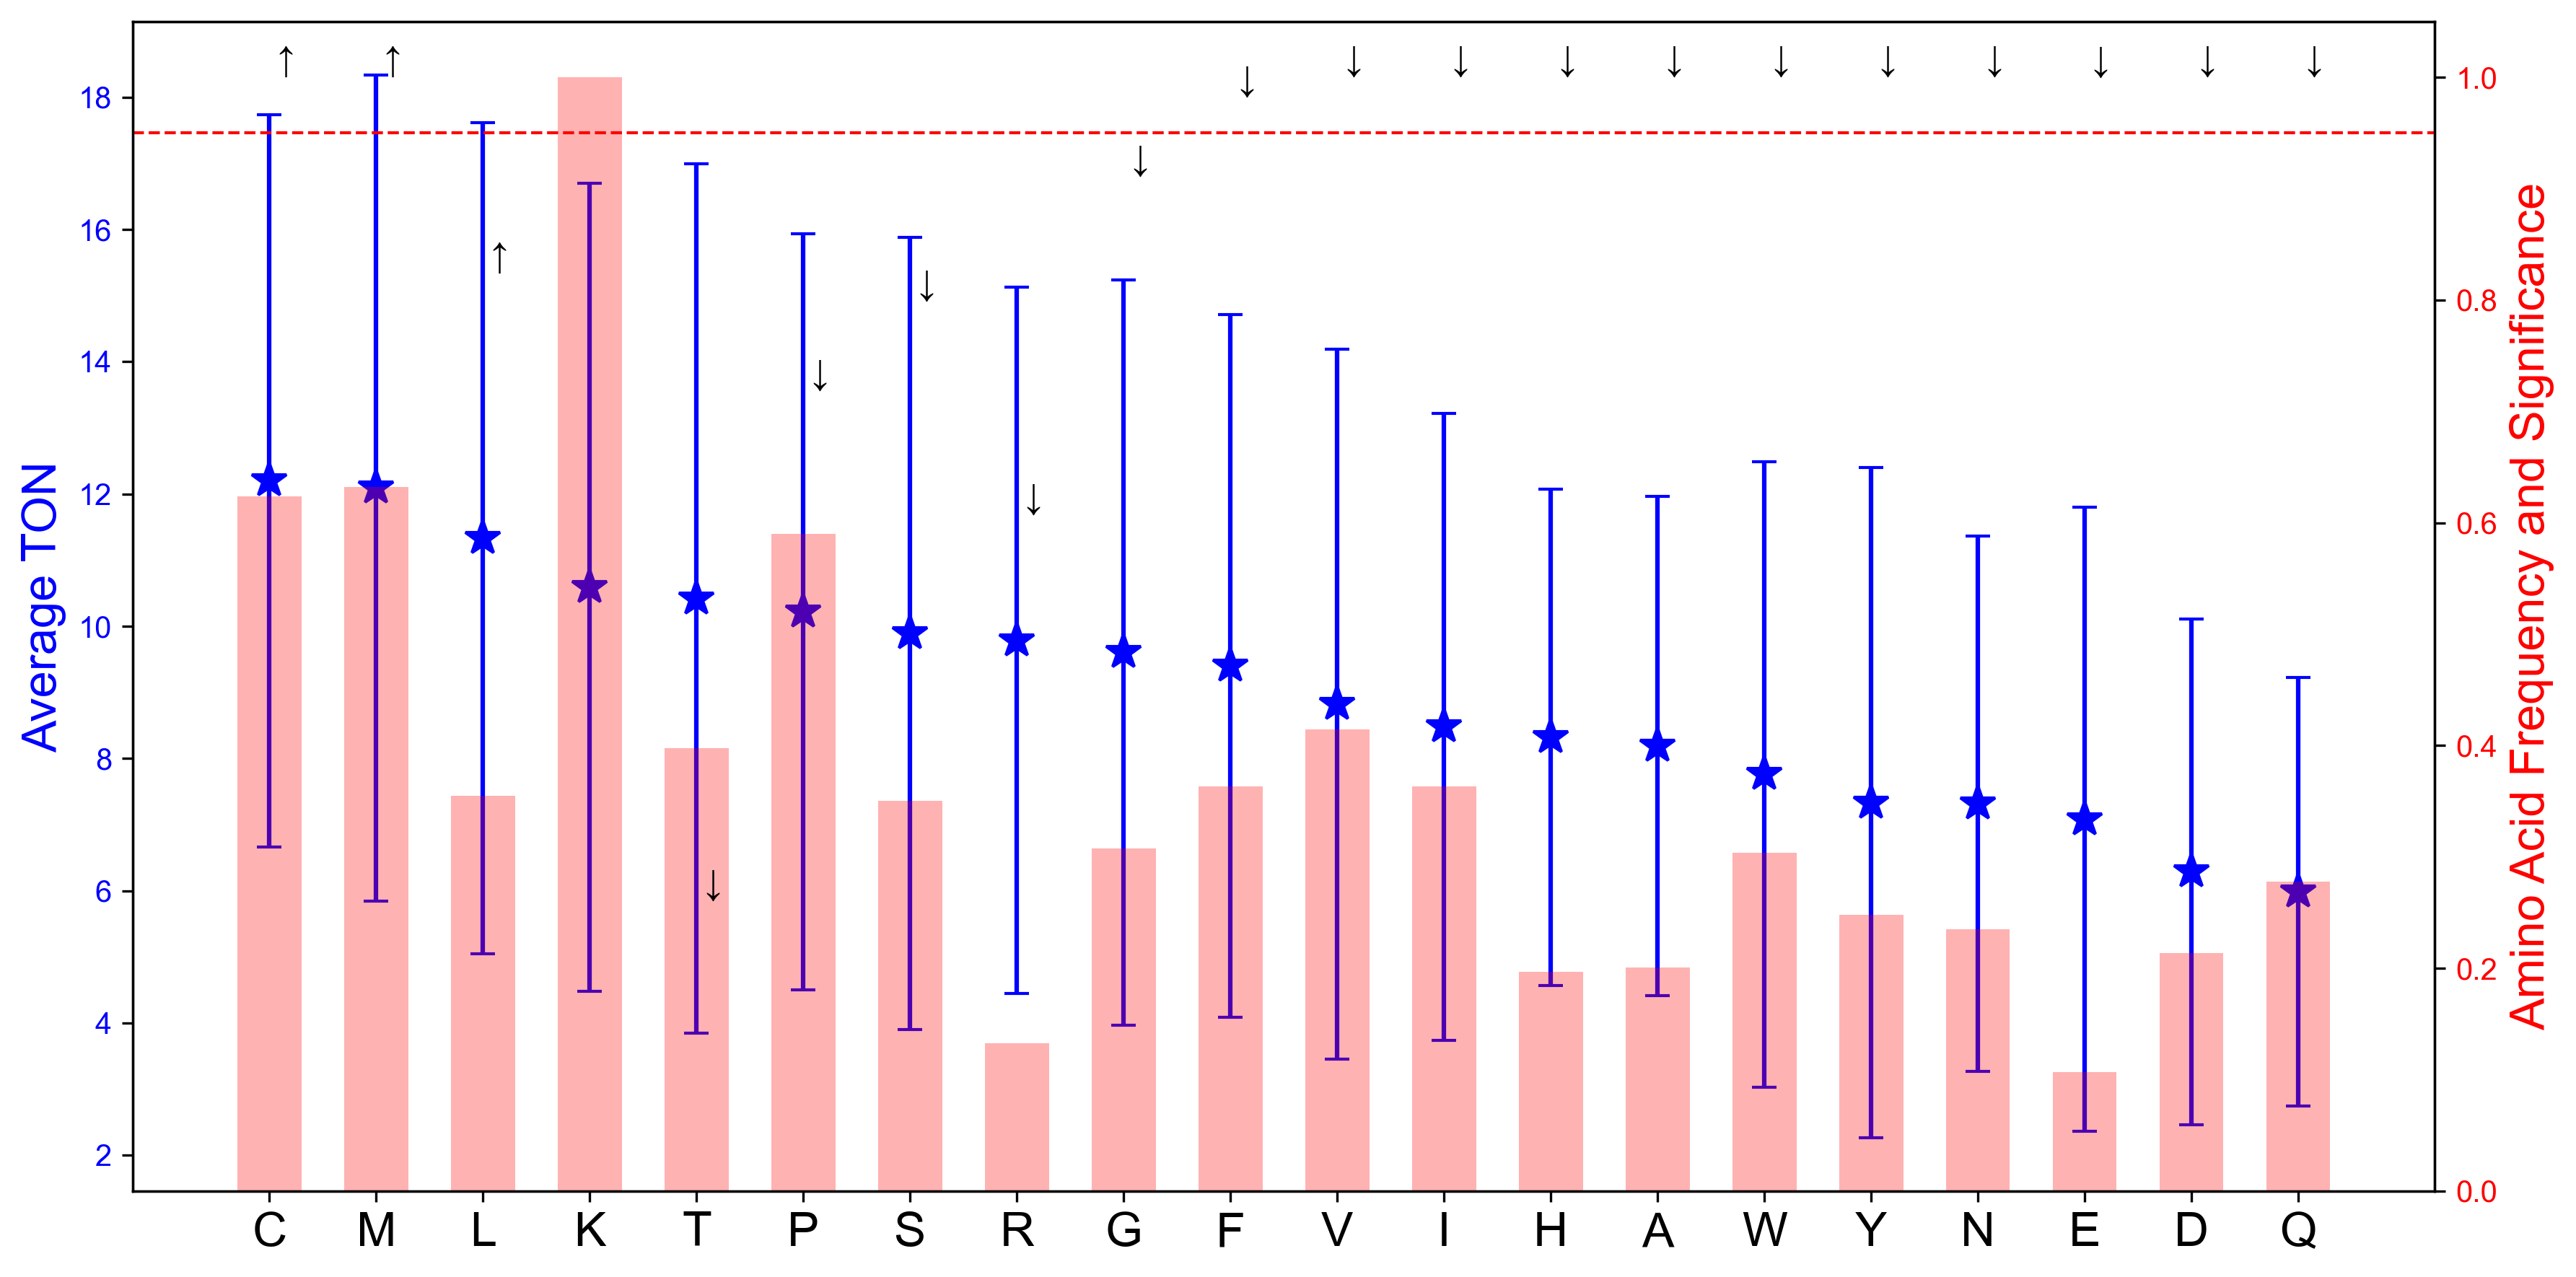

In [11]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Ensure sorted_sequences and sorted_tons are defined before this block

means = []
stds = []
ton_values_num = []
p_values = []
effect_directions = []

labels = np.unique(sorted_sequences)

for label_temp in labels:
    mask = (sorted_sequences == label_temp).any(axis=1)
    ton_with = sorted_tons[mask]
    ton_without = sorted_tons[~mask]
    
    mean_with = ton_with.mean()
    mean_without = ton_without.mean()
    
    means.append(mean_with)
    stds.append(ton_with.std())
    ton_values_num.append(sum(mask) / len(sorted_sequences))
    
    # Perform t-test
    _, p = ttest_ind(ton_with, ton_without, equal_var=False)
    p_values.append(p)
    
    # Determine direction
    if mean_with > mean_without:
        effect_directions.append("↑")
    else:
        effect_directions.append("↓")

# Convert to numpy arrays for sorting
means = np.array(means)
stds = np.array(stds)
ton_values_num = np.array(ton_values_num)
labels = np.array(labels)
p_values = np.array(p_values)
effect_directions = np.array(effect_directions)

# Sort by mean TON
sorted_indices = np.argsort(means)[::-1]
means = means[sorted_indices]
stds = stds[sorted_indices]
ton_values_num = ton_values_num[sorted_indices]
labels_sorted = labels[sorted_indices]
p_values = p_values[sorted_indices]
effect_directions = effect_directions[sorted_indices]

fig, ax1 = plt.subplots(figsize=(12, 6), dpi=300)
x = np.arange(len(labels_sorted))
width = 0.6  # total width for each bar

# → Plot Avg TON as stars with error bars (std dev), shifted left
ax1.errorbar(
    x,
    means,
    yerr = stds,
    fmt='*',             # star marker
    markersize=12,
    ecolor='blue',       # error‐bar color
    elinewidth=1.5,
    capsize=4,
    color = "blue",
    linestyle='None',
    label='Avg TON ±1σ'
)
ax1.set_ylabel('Average TON', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Center the x‑labels
ax1.set_xticks(x)
ax1.set_xticklabels(labels_sorted, fontsize=16)

# Red bars: Frequency, shifted right
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x,
    ton_values_num,
    width=width,
    capsize=4,
    alpha=0.3,
    color='red',
    label='Frequency'
)
ax2.set_ylabel('Amino Acid Frequency and Significance', color='red', fontsize=16)
ax2.tick_params(axis='y', labelcolor='red')
# Add stars and direction arrows
for i, (p, direction) in enumerate(zip(p_values, effect_directions)):
    if p < 0.001:
        annotation = f'{direction}'
    elif p < 0.01:
        annotation = f'{direction}'
    elif p < 0.05:
        annotation = f'{direction}'
    else:
        annotation = f'{direction}'
    if annotation:
        ax2.text(x[i] + 0.15, 1-p, annotation, ha='center', va='bottom', fontsize=12, color='black')
        
ax2.axhline(y=0.95, color='red', linestyle='--', linewidth=1)
fig.tight_layout()
plt.show()

In [12]:
# import matplotlib.pyplot as plt
# from scipy.stats import ttest_ind

# # Ensure sorted_sequences and sorted_tons are defined before this block
# for sorted_tons in [sorted_ton1, sorted_ton2, sorted_ton3]:
#     means = []
#     stds = []
#     ton_values_num = []
#     p_values = []
#     effect_directions = []

#     labels = np.unique(sorted_sequences)

#     for label_temp in labels:
#         mask = (sorted_sequences == label_temp).any(axis=1)
#         ton_with = sorted_tons[mask]
#         ton_without = sorted_tons[~mask]
        
#         mean_with = ton_with.mean()
#         mean_without = ton_without.mean()
        
#         means.append(mean_with)
#         stds.append(ton_with.std())
#         ton_values_num.append(sum(mask) / len(sorted_sequences))
        
#         # Perform t-test
#         _, p = ttest_ind(ton_with, ton_without, equal_var=False)
#         p_values.append(p)
        
#         # Determine direction
#         if mean_with > mean_without:
#             effect_directions.append("↑")
#         else:
#             effect_directions.append("↓")

#     # Convert to numpy arrays for sorting
#     means = np.array(means)
#     stds = np.array(stds)
#     ton_values_num = np.array(ton_values_num)
#     labels = np.array(labels)
#     p_values = np.array(p_values)
#     effect_directions = np.array(effect_directions)

#     # Sort by mean TON
#     sorted_indices = np.argsort(means)[::-1]
#     means = means[sorted_indices]
#     stds = stds[sorted_indices]
#     ton_values_num = ton_values_num[sorted_indices]
#     labels_sorted = labels[sorted_indices]
#     p_values = p_values[sorted_indices]
#     effect_directions = effect_directions[sorted_indices]

#     # Plotting
#     fig, ax1 = plt.subplots(figsize=(12, 6), dpi = 300)
#     x = np.arange(len(labels_sorted))

#     # Bar for average TON
#     bars1 = ax1.bar(x, means, yerr=stds, capsize=4, alpha=0.3, color='blue', ecolor='blue', label='Avg TON')
#     ax1.set_ylabel('Average TON', color='blue')
#     ax1.tick_params(axis='y', labelcolor='blue')
#     ax1.set_xticks(x)
#     ax1.set_xticklabels(labels_sorted)

#     # Second axis for frequency
#     ax2 = ax1.twinx()
#     bars2 = ax2.bar(x, ton_values_num, capsize=4, alpha=0.3, color='red', label='Frequency')
#     ax2.set_ylabel('Amino Acid Frequency and P-value', color='red')
#     ax2.tick_params(axis='y', labelcolor='red')

#     # Add stars and direction arrows
#     for i, (p, direction) in enumerate(zip(p_values, effect_directions)):
#         if p < 0.001:
#             annotation = f'{direction}'
#         elif p < 0.01:
#             annotation = f'{direction}'
#         elif p < 0.05:
#             annotation = f'{direction}'
#         else:
#             annotation = f'{direction}'
#         if annotation:
#             ax2.text(x[i] + 0.15, 1-p, annotation, ha='center', va='bottom', fontsize=12, color='black')
            
#     ax2.axhline(y=0.95, color='red', linestyle='--', linewidth=1)

#     fig.tight_layout()
#     plt.title('Effect of Amino Acid Presence on TON (with Significance and Direction)')
#     plt.show()
#     plt.close()

In [13]:
_percentage_all = []
for i in range(1, len(data_all_origin) + 1):
    data_temp = pd.concat(data_all_origin[0:i])

    sequence_temp = np.array([re.search(r'(?:^\d+-)?(?P<seq>(?:[A-Z],?)+)(?:-\d+)?$', text).group("seq").split(',') for text in data_temp["exp"].values])
    _percentage_batch = []
    for label_temp in labels:
        _percentage = ((sequence_temp == label_temp).sum(axis=1) > 0).sum() / len(sequence_temp)
        _percentage_batch.append(_percentage)
    _percentage_all.append(_percentage_batch)
_percentage_all = np.array(_percentage_all)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22124\1181740327.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', n_labels)


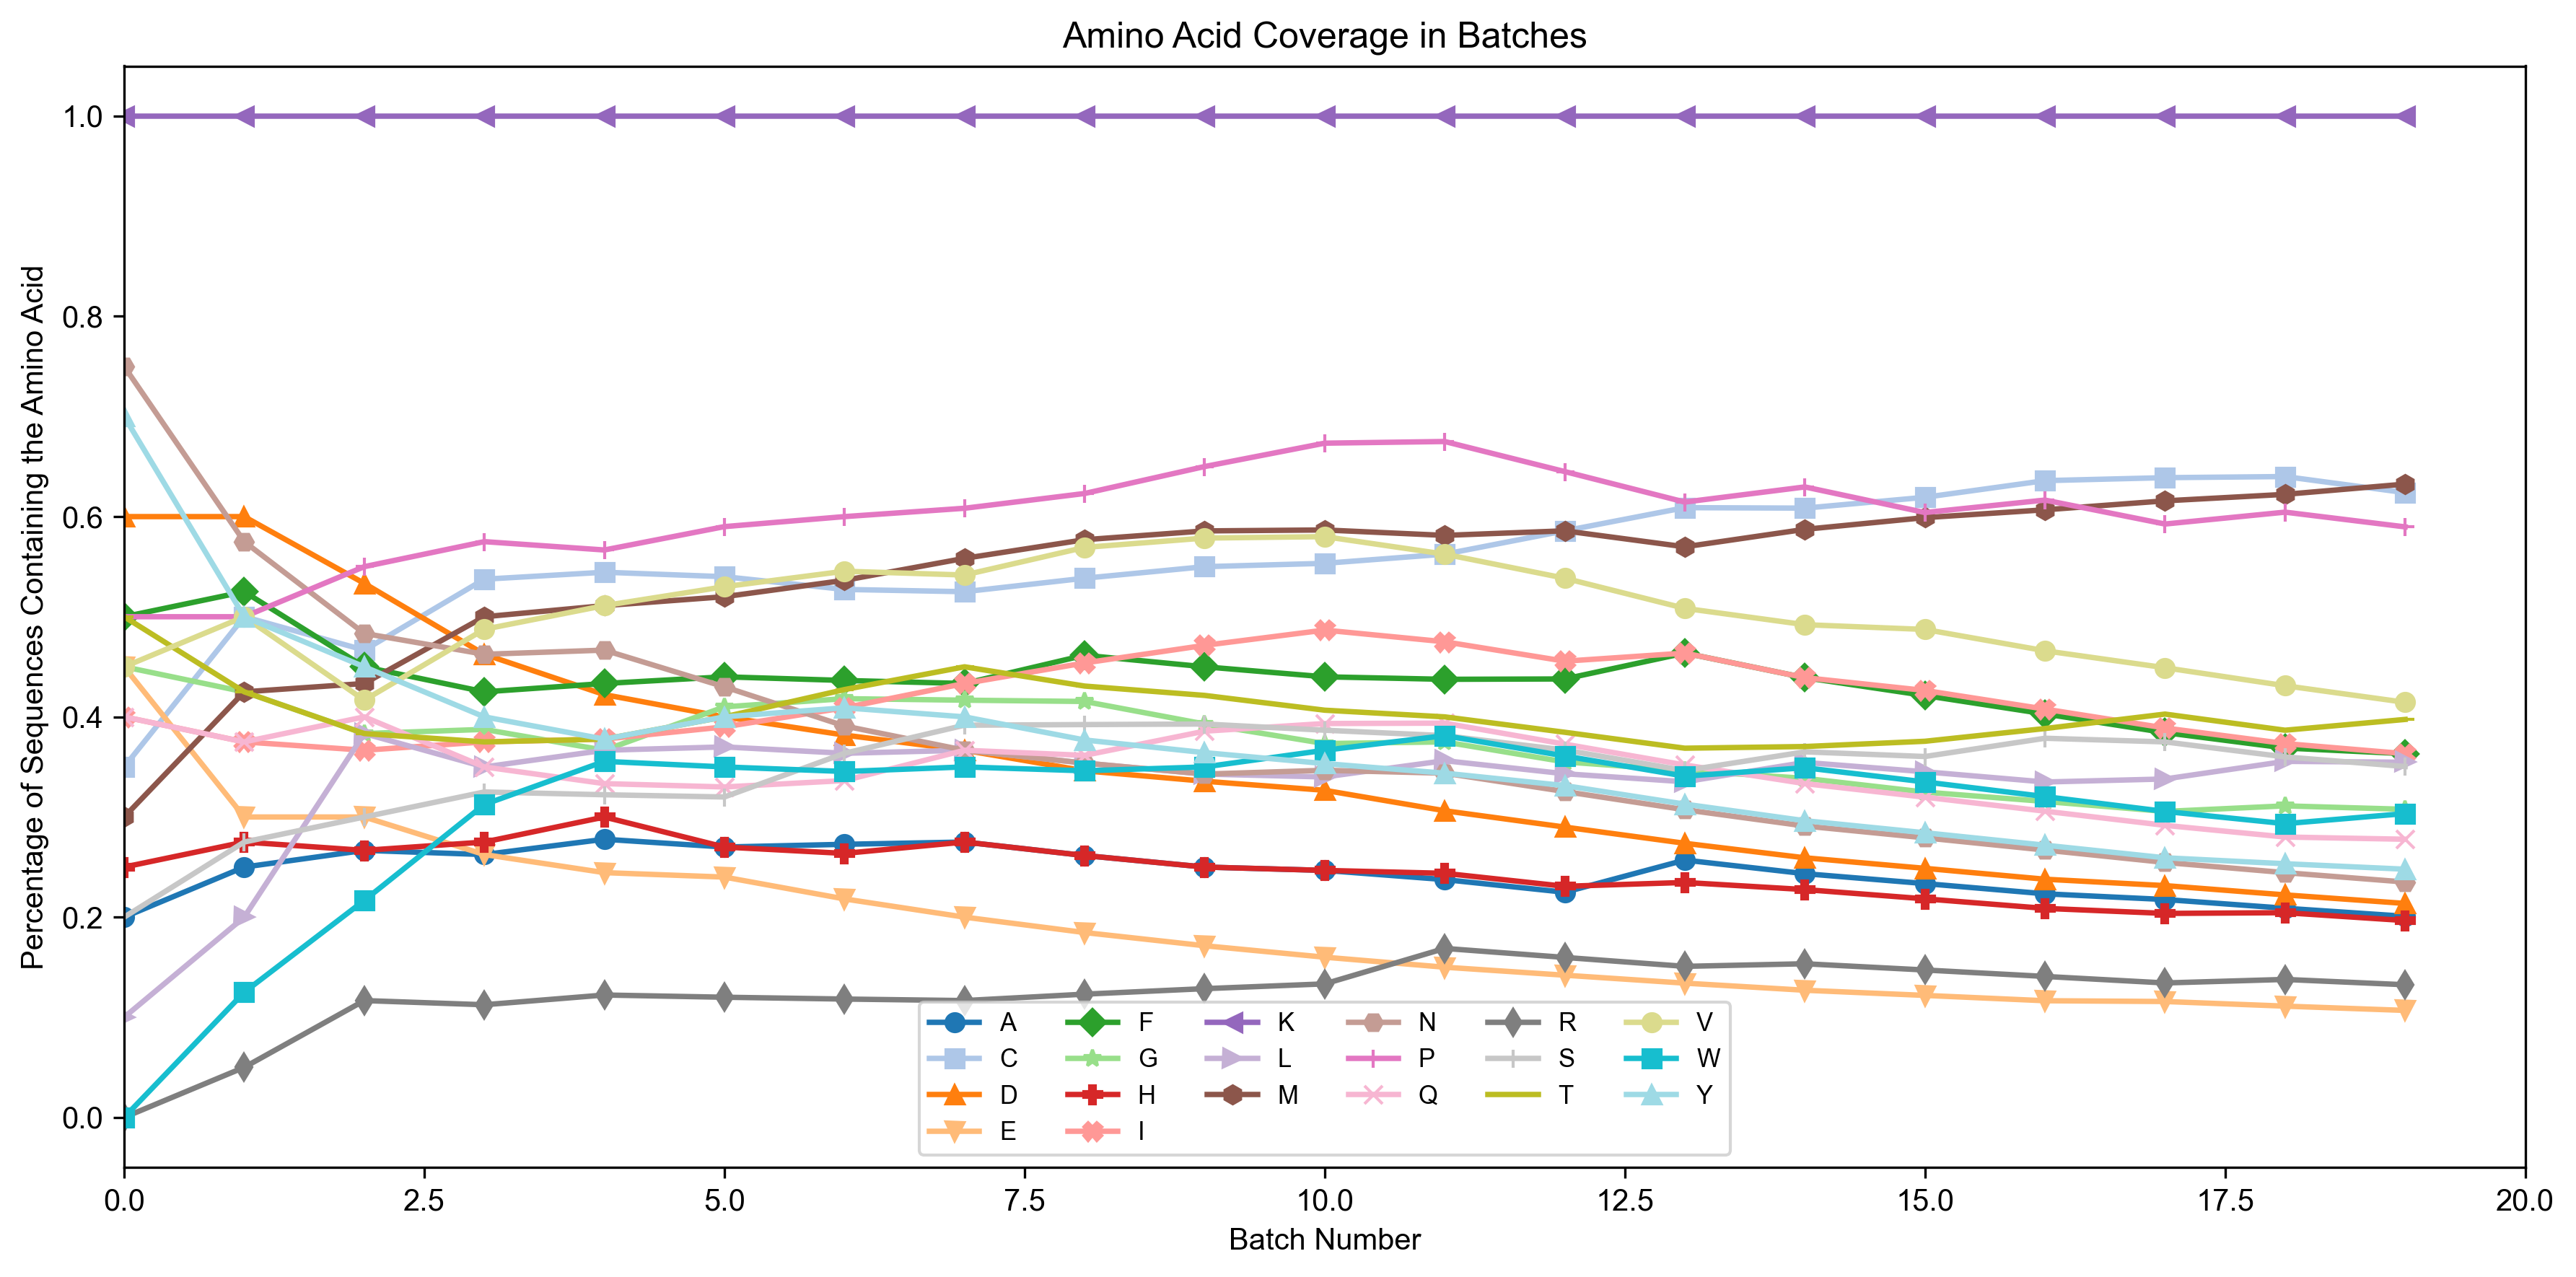

In [14]:
n_labels = len(labels)

# Use distinct colormap and marker cycle
cmap = cm.get_cmap('tab20', n_labels)
marker_styles = ['o', 's', '^', 'v', 'D', '*', 'P', 'X', '<', '>', 'h', 'H', '+', 'x', 'd', '|', '_']

plt.figure(figsize=(12, 6), dpi = 300)

for idx, label_temp in enumerate(labels):
    y_values = _percentage_all[:, idx]
    plt.plot(
        y_values,
        label=label_temp,
        color=cmap(idx),
        marker=marker_styles[idx % len(marker_styles)],
        linestyle='-',  # or '--', etc., if further distinction is needed
        linewidth=1.8
    )
    
plt.xlim(0, 20)
plt.xlabel("Batch Number")
plt.ylabel("Percentage of Sequences Containing the Amino Acid")
plt.title("Amino Acid Coverage in Batches")
plt.legend(ncol=6, fontsize='small')
plt.tight_layout()
plt.show()

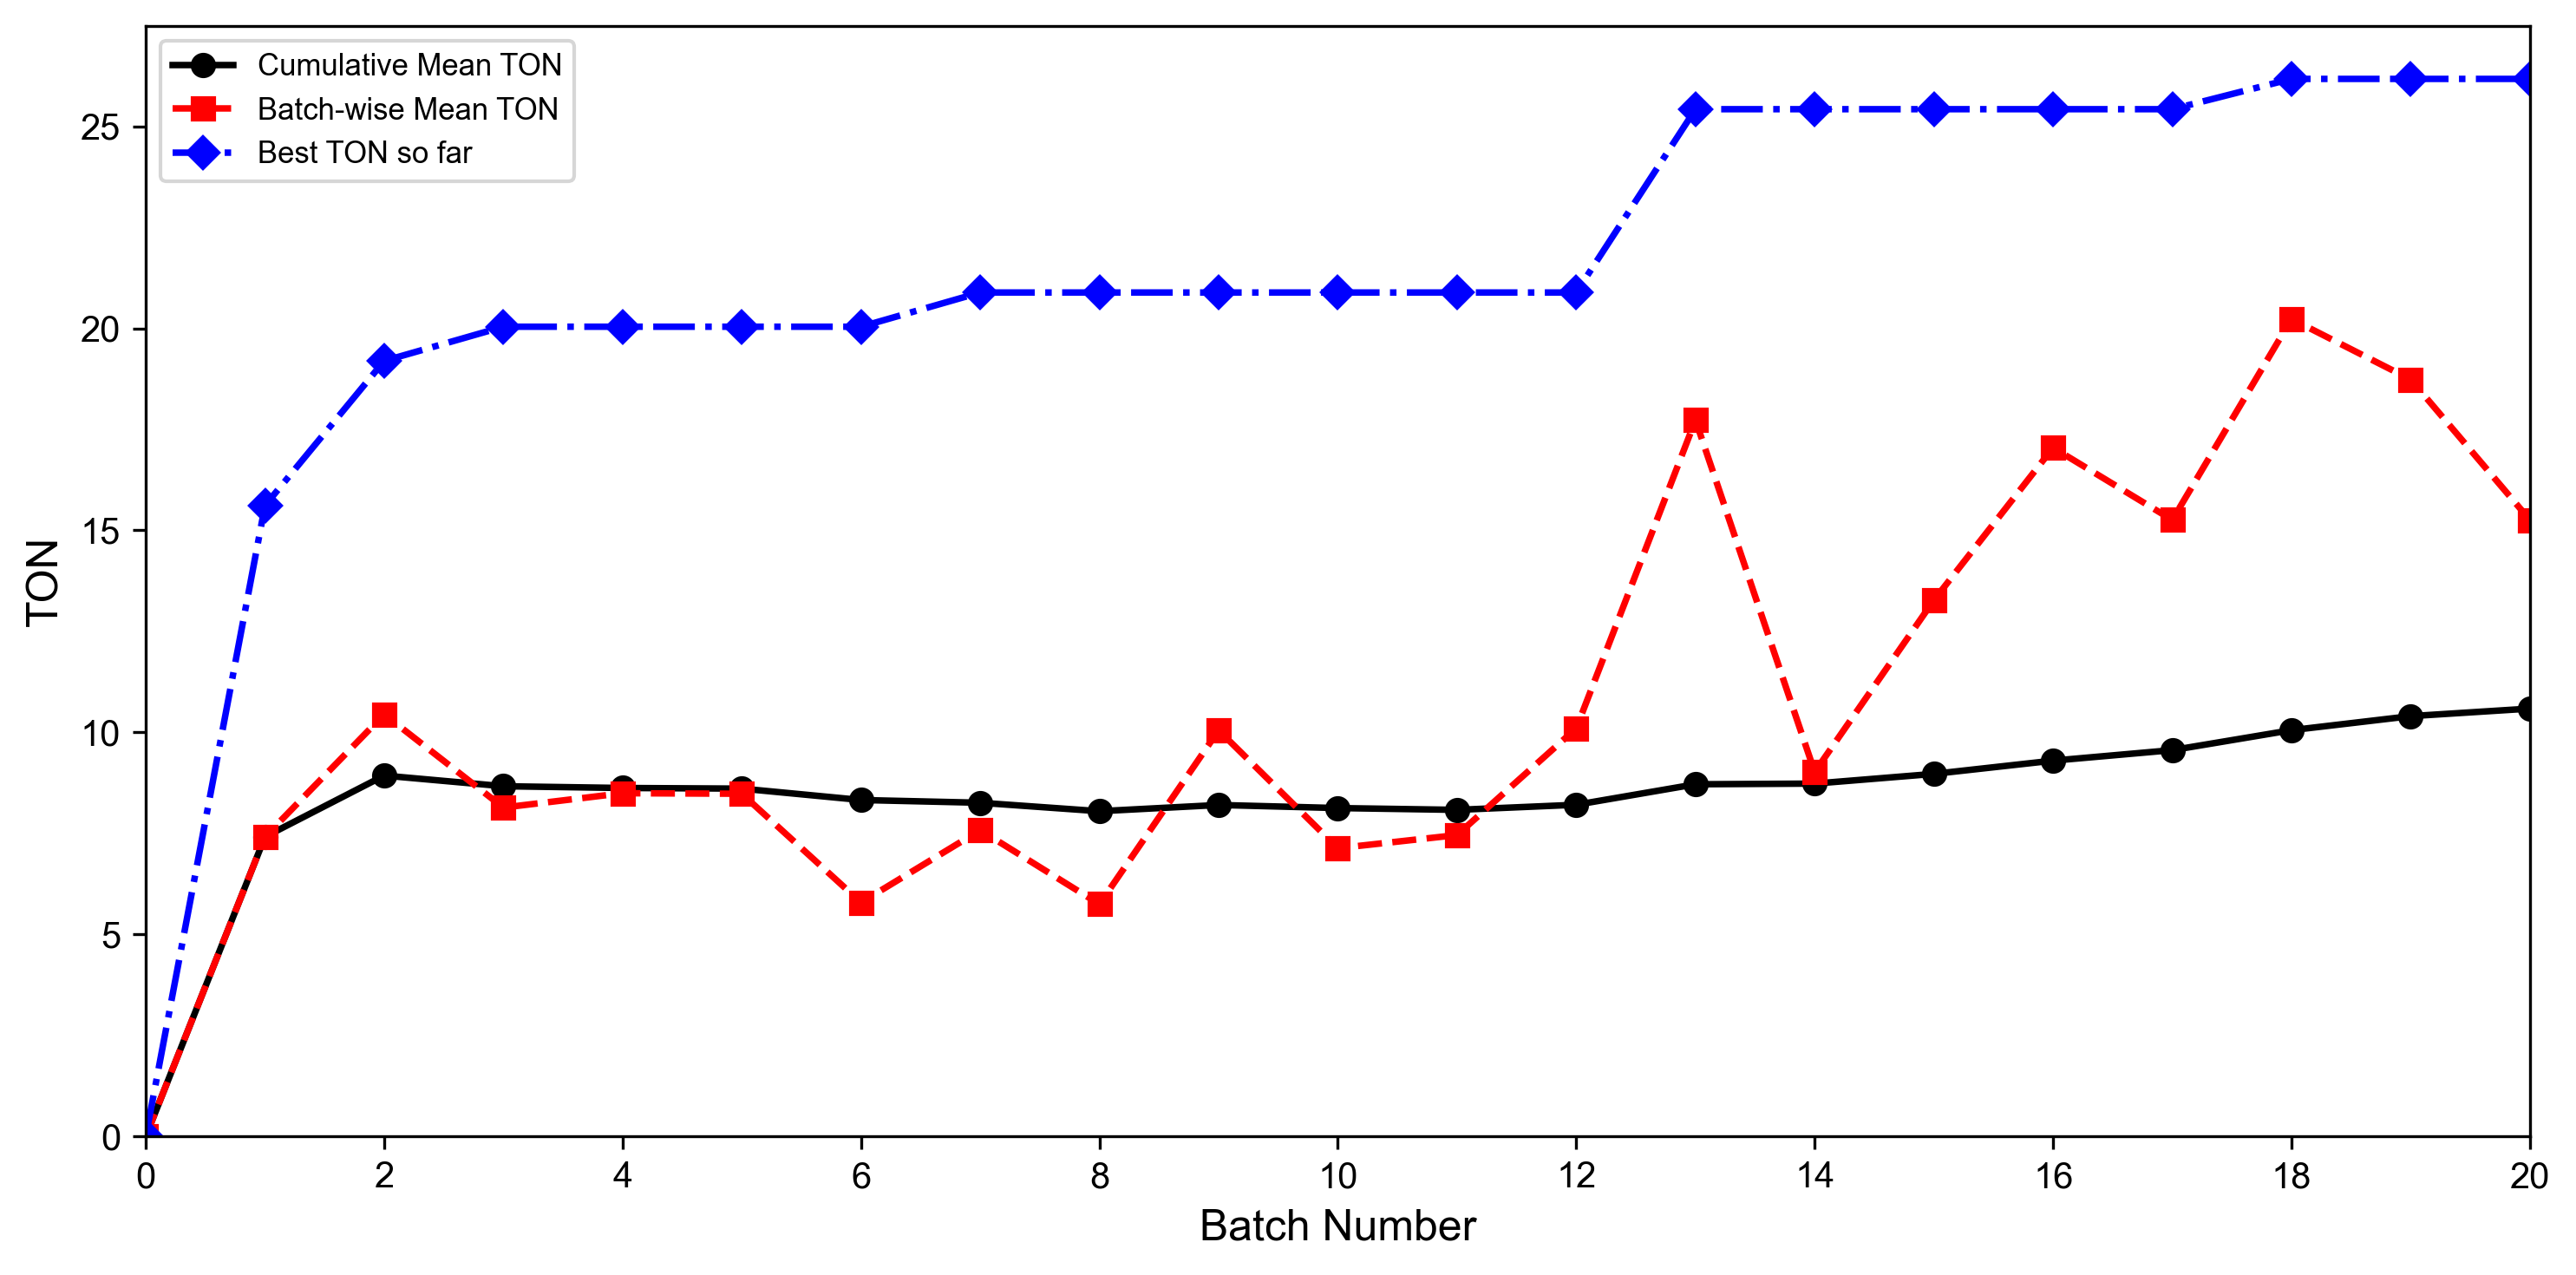

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ——————————————————————————————————————————————
# 1) Compute cumulative & batch‑wise stats + running max
mean_ton_all   = []
best_ton_all   = []
mean_ton_batch = []

for i in range(1, len(data_all_origin) + 1):
    data_temp = pd.concat(data_all_origin[:i])
    tons_temp = data_temp["ton"].values
    mean_ton_all.append(tons_temp.mean())
    best_ton_all.append(tons_temp.max())

for df in data_all_origin:
    tons_batch = df["ton"].values
    mean_ton_batch.append(tons_batch.mean())
    
mean_ton_all = [0] + mean_ton_all
mean_ton_all   = np.array(mean_ton_all)

best_ton_all = [0] + best_ton_all
best_ton_all   = np.array(best_ton_all)

mean_ton_batch = [0] + mean_ton_batch
mean_ton_batch = np.array(mean_ton_batch)
batch_count    = len(mean_ton_all)

# 2) X axis: batches numbered 0…N-1
x = np.arange(batch_count)

# ——————————————————————————————————————————————
# 3) Single-axis plot without error bars
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# Cumulative mean TON (black)
ax.plot(
    x,
    mean_ton_all,
    marker='o',
    linestyle='-',
    color='black',
    linewidth=1.8,
    markersize=6,
    label="Cumulative Mean TON"
)

# Batch‑wise mean TON (red)
ax.plot(
    x,
    mean_ton_batch,
    marker='s',
    linestyle='--',
    color='red',
    linewidth=1.8,
    markersize=6,
    label="Batch-wise Mean TON"
)

# Best TON so far (blue)
ax.plot(
    x,
    best_ton_all,
    marker='D',
    linestyle='-.',
    color='blue',
    linewidth=1.8,
    markersize=6,
    label="Best TON so far"
)

# Styling
ax.set_xlabel("Batch Number", fontsize=12)
ax.set_ylabel("TON", fontsize=12)

# Integer x‑ticks and axis limits
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim(0, batch_count - 1)
ax.set_ylim(bottom=0)

# Legend
ax.legend(loc="upper left", fontsize='small')

plt.tight_layout()
plt.show()

In [16]:
sorted_sequences_original = sorted_sequences.copy()
sorted_tons_original = sorted_tons.copy()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22124\2577646717.py:18: RuntimeWarning: Mean of empty slice.
  mean_with = ton_with.mean()
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22124\2577646717.py:19: RuntimeWarning: Mean of empty slice.
  mean_without = ton_without.mean()


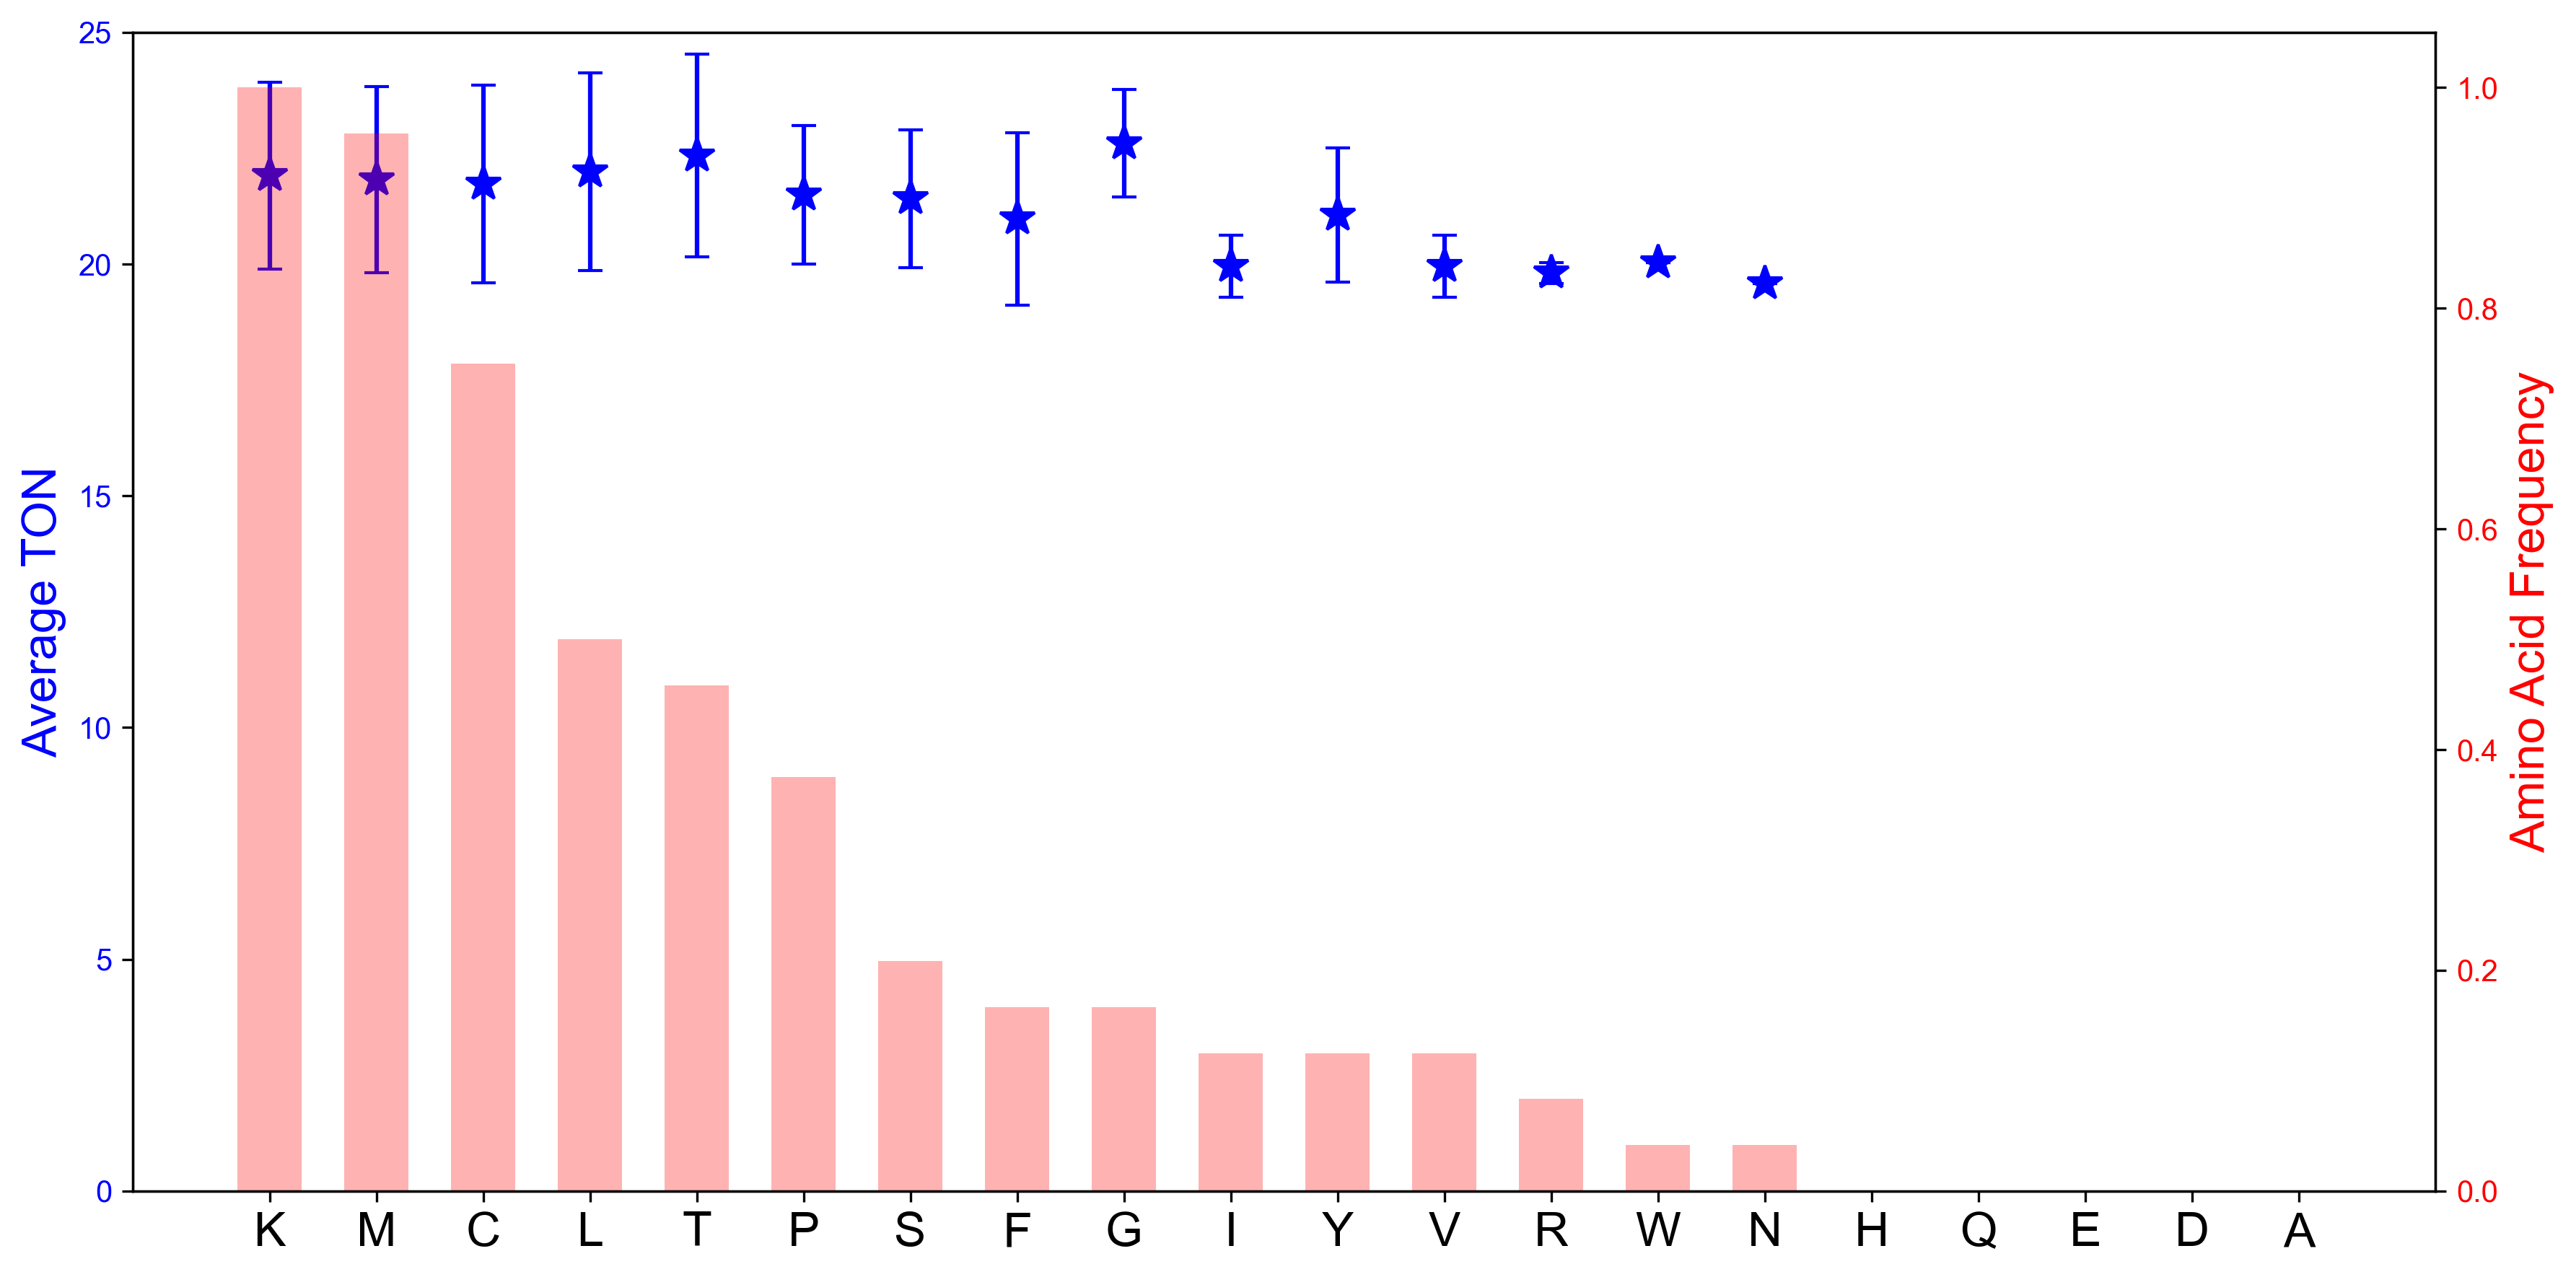

0.25625


In [17]:
# plot the content
means = []
stds = []
ton_values_num = []
p_values = []
effect_directions = []

sorted_sequences = sorted_sequences_original[0:24]
sorted_tons = sorted_tons_original[0:24]

labels = np.unique(sorted_sequences_original)

for label_temp in labels:
    mask = (sorted_sequences == label_temp).any(axis=1)
    ton_with = sorted_tons[mask]
    ton_without = sorted_tons[~mask]
    
    mean_with = ton_with.mean()
    mean_without = ton_without.mean()
    
    means.append(mean_with)
    stds.append(ton_with.std())
    ton_values_num.append(sum(mask) / len(sorted_sequences))

# Convert to numpy arrays for sorting
means = np.array(means)
stds = np.array(stds)
ton_values_num = np.array(ton_values_num)
labels = np.array(labels)

# Sort by mean TON
sorted_indices = np.argsort(ton_values_num)[::-1]
means = means[sorted_indices]
stds = stds[sorted_indices]
ton_values_num = ton_values_num[sorted_indices]
labels_sorted = labels[sorted_indices]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=300)
x = np.arange(len(labels_sorted))
width = 0.6   # total horizontal span for each “pair”

# — Average TON as stars with std dev error‐bars, shifted left:
ax1.errorbar(
    x,
    means,
    yerr=stds,
    fmt='*',             # star marker
    markersize=12,
    ecolor='blue',       # error‐bar color
    elinewidth=1.5,
    color = "blue",
    capsize=4,
    linestyle='None',
    label='Avg TON ±1σ'
)
ax1.set_ylabel('Average TON', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Center the x‐labels between the two series
ax1.set_xticks(x)
ax1.set_xticklabels(labels_sorted, fontsize=16)
ax1.set_ylim(0, 25)

# — Frequency bars on a second axis, shifted right:
ax2 = ax1.twinx()
ax2.bar(
    x,
    ton_values_num,
    width=width,
    alpha=0.3,
    color='red',
    label='Frequency'
)
ax2.set_ylabel('Amino Acid Frequency', color='red', fontsize=16)
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
# Legend for the Frequency bars on ax2
plt.show()

coverage_1 = ton_values_num

print(coverage_1.mean())

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22124\3090351429.py:19: RuntimeWarning: Mean of empty slice.
  mean_without = ton_without.mean()
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


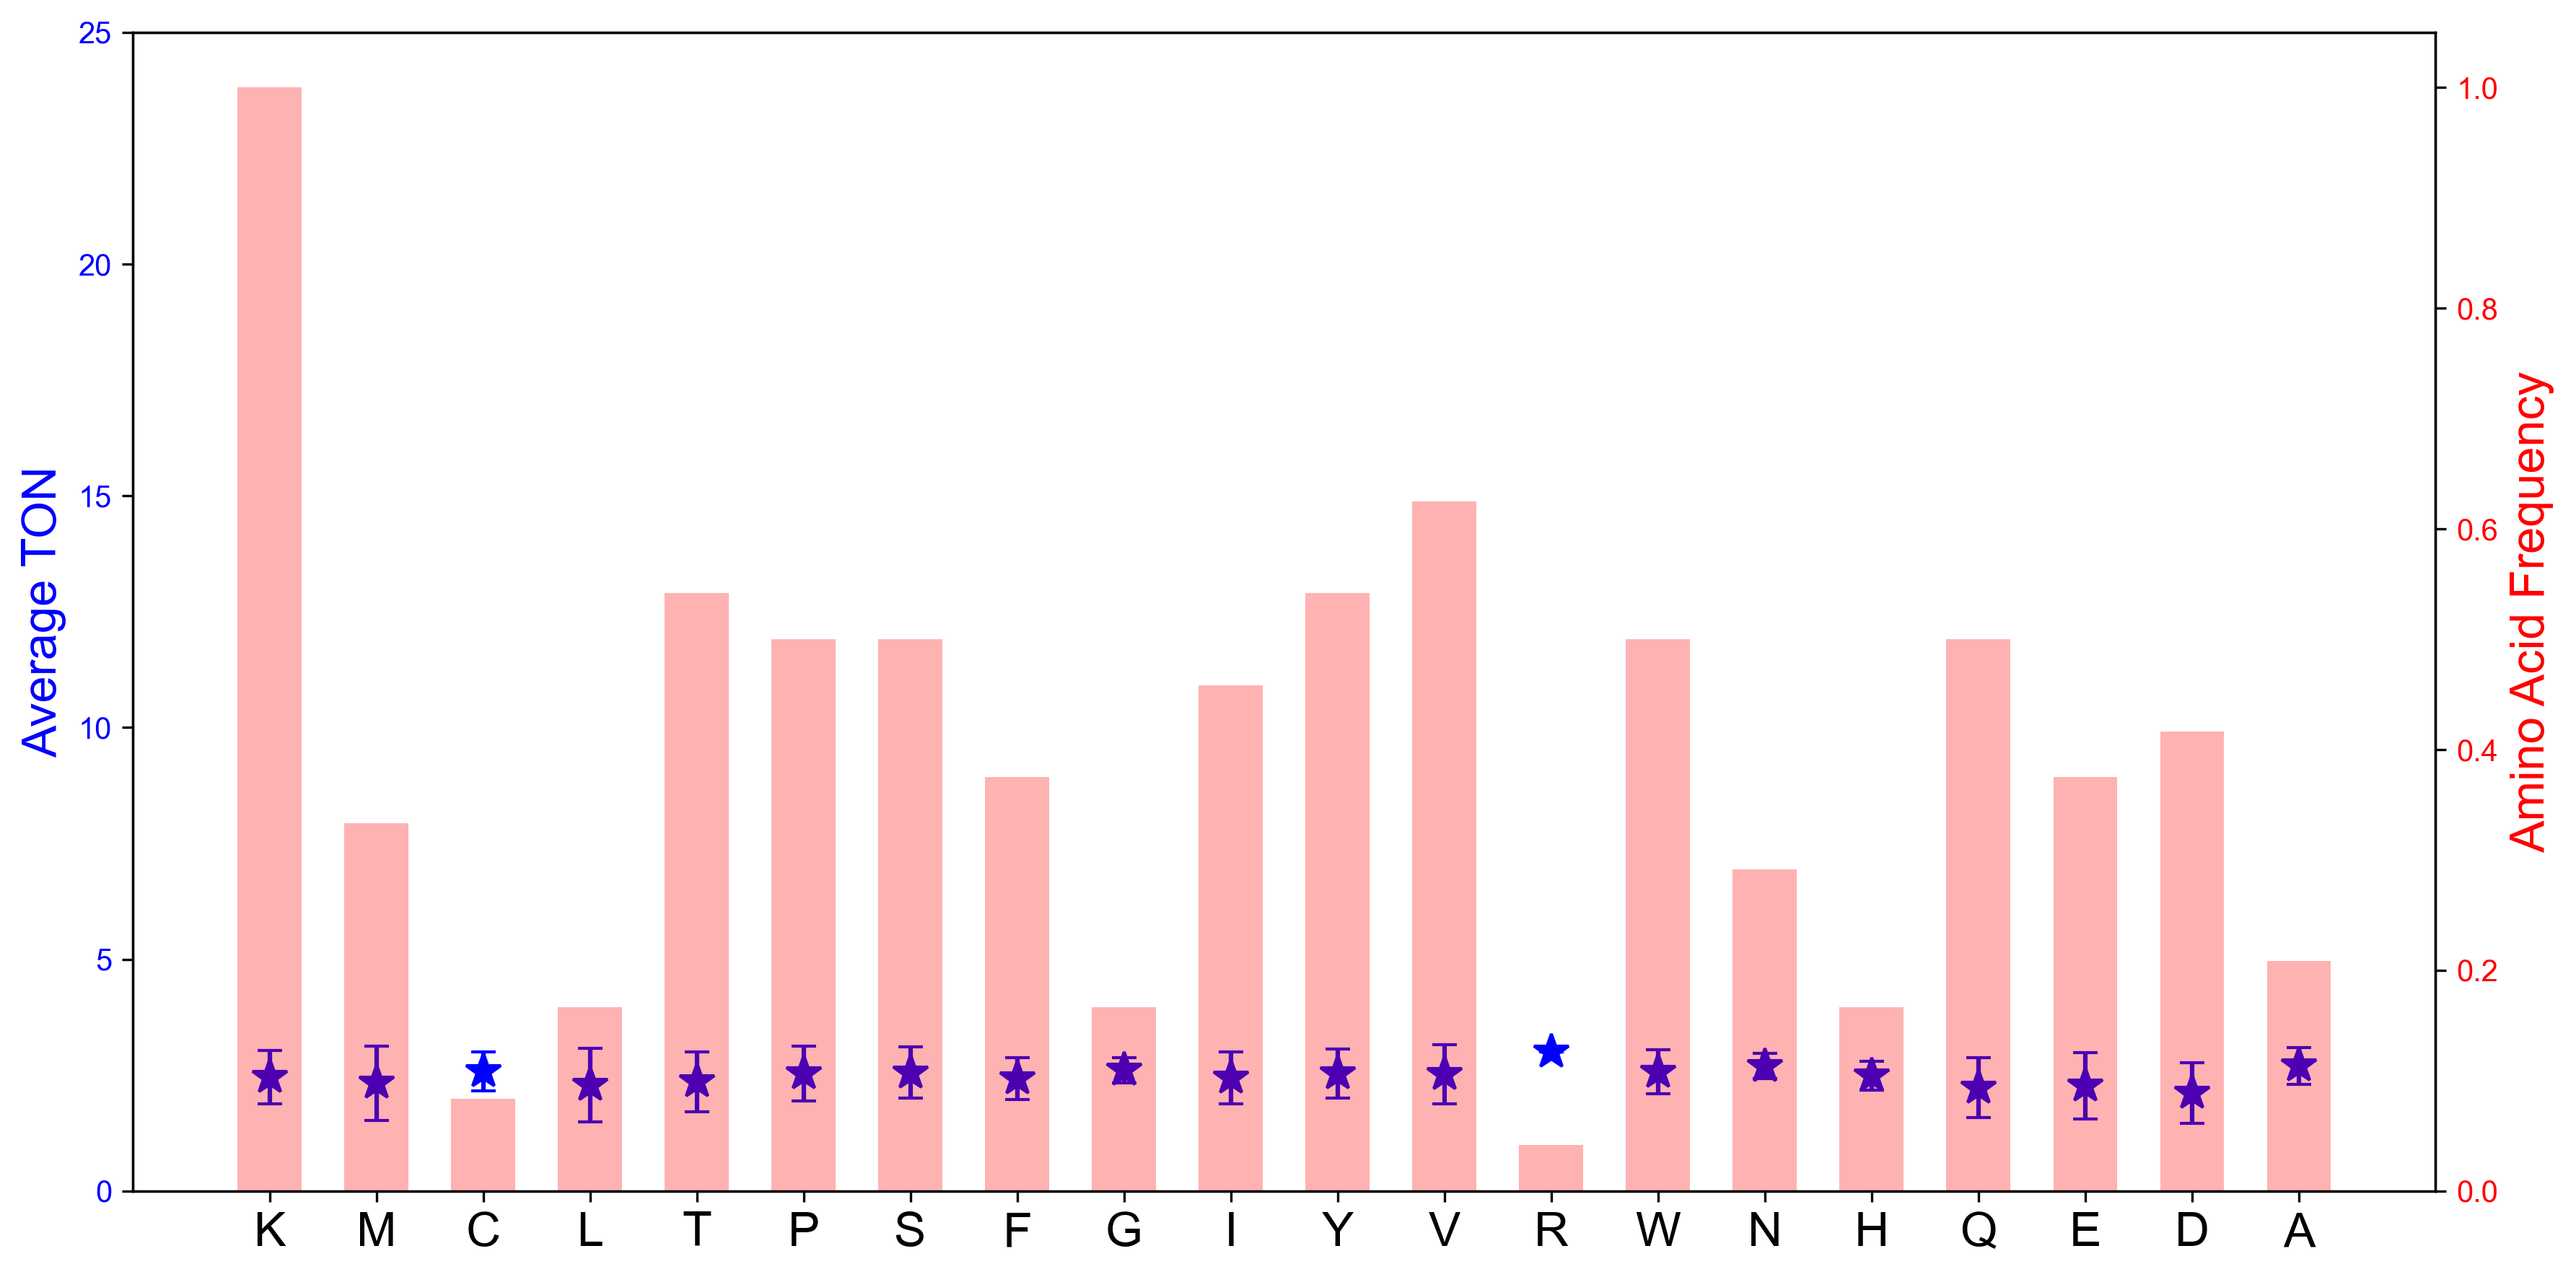

In [18]:
# plto the content
means = []
stds = []
ton_values_num = []
p_values = []
effect_directions = []

sorted_sequences = sorted_sequences_original[-24:]
sorted_tons = sorted_tons_original[-24:]

labels = np.unique(sorted_sequences_original)

for label_temp in labels:
    mask = (sorted_sequences == label_temp).any(axis=1)
    ton_with = sorted_tons[mask]
    ton_without = sorted_tons[~mask]
    
    mean_with = ton_with.mean()
    mean_without = ton_without.mean()
    
    means.append(mean_with)
    stds.append(ton_with.std())
    ton_values_num.append(sum(mask) / len(sorted_sequences))

# Convert to numpy arrays for sorting
means = np.array(means)
stds = np.array(stds)
ton_values_num = np.array(ton_values_num)
labels = np.array(labels)

# Sort by mean TON
# sorted_indices = np.arange(len(means))
means = means[sorted_indices]
stds = stds[sorted_indices]
ton_values_num = ton_values_num[sorted_indices]
labels_sorted = labels[sorted_indices]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=300)
x = np.arange(len(labels_sorted))
width = 0.6   # total horizontal span for each “pair”

# — Average TON as stars with std dev error‐bars, shifted left:
ax1.errorbar(
    x,
    means,
    yerr=stds,
    fmt='*',             # star marker
    markersize=12,
    ecolor='blue',       # error‐bar color
    elinewidth=1.5,
    color = "blue",
    capsize=4,
    linestyle='None',
    label='Avg TON ±1σ'
)
ax1.set_ylabel('Average TON', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Center the x‐labels between the two series
ax1.set_xticks(x)
ax1.set_xticklabels(labels_sorted, fontsize=16)
ax1.set_ylim(0, 25)

# — Frequency bars on a second axis, shifted right:
ax2 = ax1.twinx()
ax2.bar(
    x,
    ton_values_num,
    width=width,
    alpha=0.3,
    color='red',
    label='Frequency'
)
ax2.set_ylabel('Amino Acid Frequency', color='red', fontsize=16)
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
# Legend for the Frequency bars on ax2
plt.show()

coverage_2 = ton_values_num

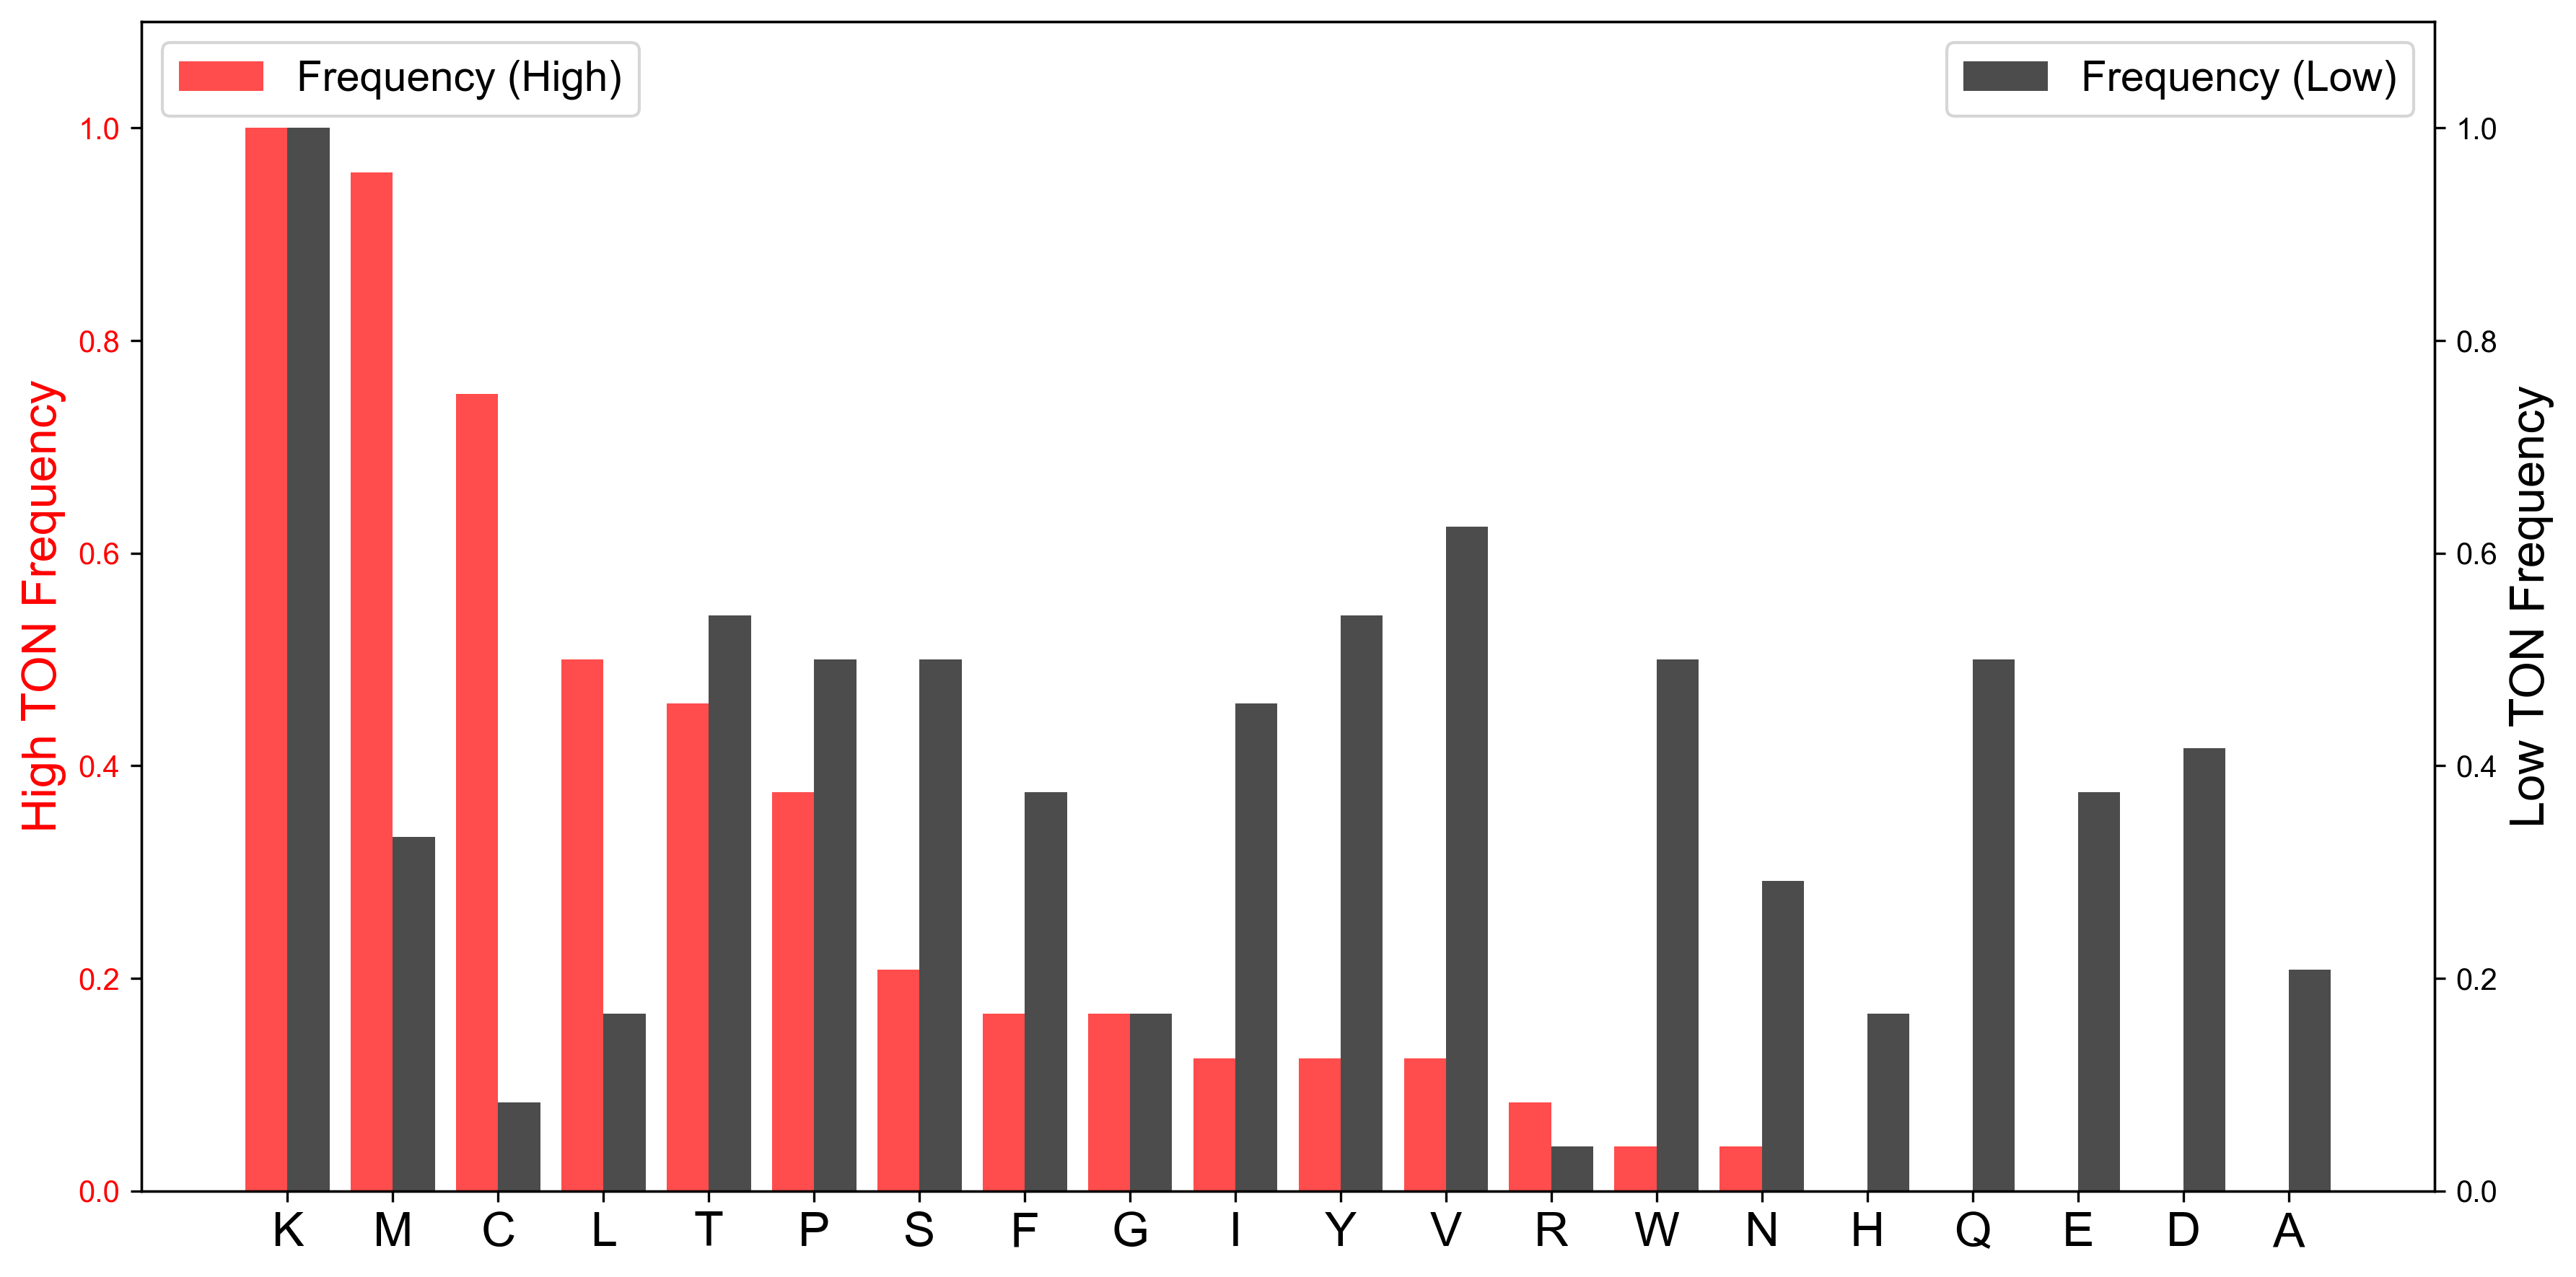

In [19]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=300)
x = np.arange(len(labels_sorted))
width = 0.4  # total bar width

# High‑TON frequency bars (shifted left)
bars1 = ax1.bar(
    x - width/2,
    coverage_1,
    width=width,
    alpha=0.7,
    color='red',
    label='Frequency (High)'
)
ax1.set_ylabel('High TON Frequency', color='red', fontsize=16)
ax1.tick_params(axis='y', labelcolor='red')

# X‑ticks in the center
ax1.set_xticks(x)
ax1.set_xticklabels(labels_sorted, fontsize=16)
ax1.set_ylim(0, 1.1)

# Low‑TON frequency bars on twin‑axis (shifted right)
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + width/2,
    coverage_2,
    width=width,
    alpha=0.7,
    color='black',
    label='Frequency (Low)'
)
ax2.set_ylabel('Low TON Frequency', color='black', fontsize=16)
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 1.1)

# Separate legends so they don’t overlap
ax1.legend(loc='upper left', fontsize = 14)
ax2.legend(loc='upper right', fontsize = 14)

fig.tight_layout()
plt.show()

In [20]:
import numpy as np

# --- inputs you already have ------------------------------------
# sorted_sequences_original : array-like, shape (N, L)  # sequences sorted by TON (desc)
# sorted_tons_original      : array-like, shape (N,)    # corresponding TON values
TOP_K = 24   # use 24 as in your code; change if needed

# --- helper to get stats for a subset ----------------------------
def aa_stats_for_subset(seqs_subset, tons_subset, all_labels):
    means, stds, freqs = [], [], []
    for lab in all_labels:
        mask = (seqs_subset == lab).any(axis=1)
        ton_with    = tons_subset[mask]
        ton_without = tons_subset[~mask]   # (unused here but kept for parity)

        means.append(ton_with.mean() if ton_with.size else np.nan)
        stds.append(ton_with.std(ddof=1) if ton_with.size > 1 else 0.0)
        freqs.append(mask.sum() / len(seqs_subset))
    return np.array(means), np.array(stds), np.array(freqs)

# --- 1. Split top / bottom subsets -------------------------------
seqs_hi = sorted_sequences_original[:TOP_K]
tons_hi = sorted_tons_original[:TOP_K]

seqs_lo = sorted_sequences_original[-TOP_K:]
tons_lo = sorted_tons_original[-TOP_K:]

# --- 2. All amino-acid labels (use entire dataset to keep axes aligned)
labels = np.unique(sorted_sequences_original)

# --- 3. Compute stats for each subset ----------------------------
means_hi, std_hi, coverage_1 = aa_stats_for_subset(seqs_hi, tons_hi, labels)
means_lo, std_lo, coverage_2 = aa_stats_for_subset(seqs_lo, tons_lo, labels)

# --- 4. Choose an ordering for labels ----------------------------
# Example: order by high-frequency coverage descending, then by label
sorted_indices = np.lexsort((labels, -coverage_1))
labels_sorted  = labels[sorted_indices]

# Reorder everything accordingly
means_hi   = means_hi[sorted_indices]
std_hi     = std_hi[sorted_indices]
coverage_1 = coverage_1[sorted_indices]

means_lo   = means_lo[sorted_indices]
std_lo     = std_lo[sorted_indices]
coverage_2 = coverage_2[sorted_indices]

# --- 5. X positions for plotting --------------------------------
x = np.arange(len(labels_sorted))

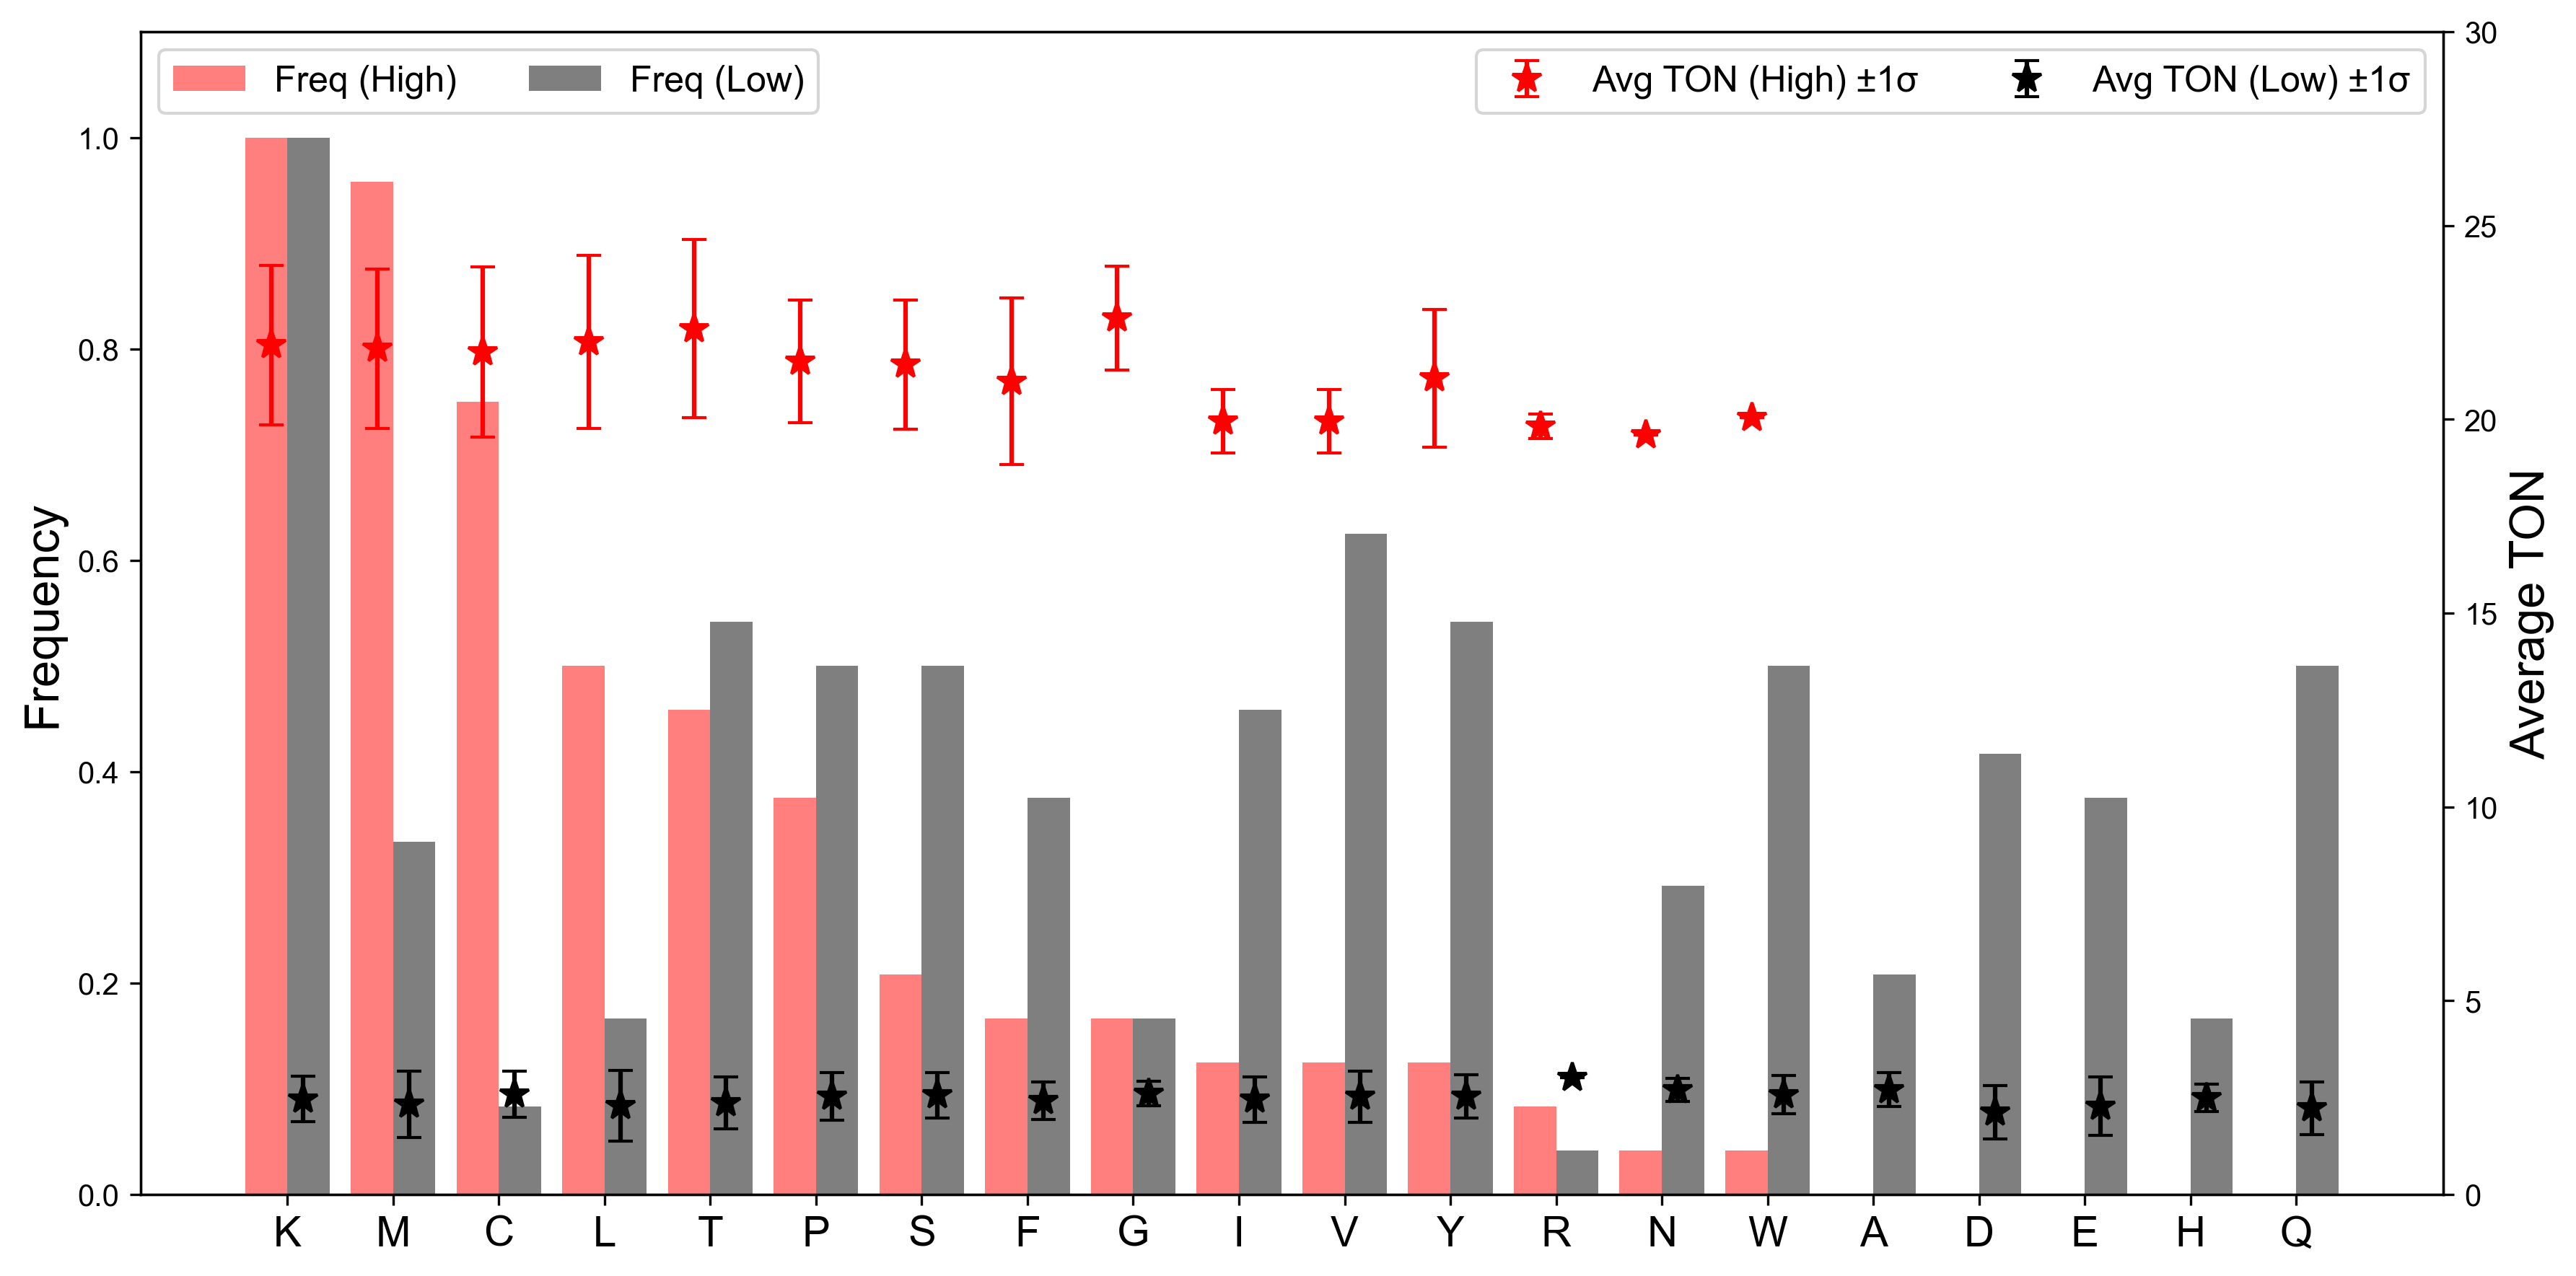

In [21]:
fig, ax_freq = plt.subplots(figsize=(12, 6), dpi=300)
width = 0.4

# Frequencies (same as before)
ax_freq.bar(x - width/2, coverage_1, width=width, alpha=0.5, color='red',   label='Freq (High)')
ax_freq.bar(x + width/2, coverage_2, width=width, alpha=0.5, color='black', label='Freq (Low)')
ax_freq.set_ylabel('Frequency', fontsize=16)
ax_freq.set_xticks(x)
ax_freq.set_xticklabels(labels_sorted, fontsize=14)
ax_freq.set_ylim(0, 1.1)

# TON stars in original red/black
ax_ton = ax_freq.twinx()
ax_ton.errorbar(x - 0.15, means_hi, yerr=std_hi,
                fmt='*', markersize=10, capsize=4,
                ecolor='red', color='red',
                linestyle='None', label='Avg TON (High) ±1σ')
ax_ton.errorbar(x + 0.15, means_lo, yerr=std_lo,
                fmt='*', markersize=10, capsize=4,
                ecolor='black', color='black',
                linestyle='None', label='Avg TON (Low) ±1σ')
ax_ton.set_ylabel('Average TON', fontsize=16)
ax_ton.set_ylim(0, 30)

ax_freq.legend(loc='upper left', fontsize=12, ncol=2)
ax_ton.legend(loc='upper right', fontsize=12, ncol=2)

fig.tight_layout()
plt.show()


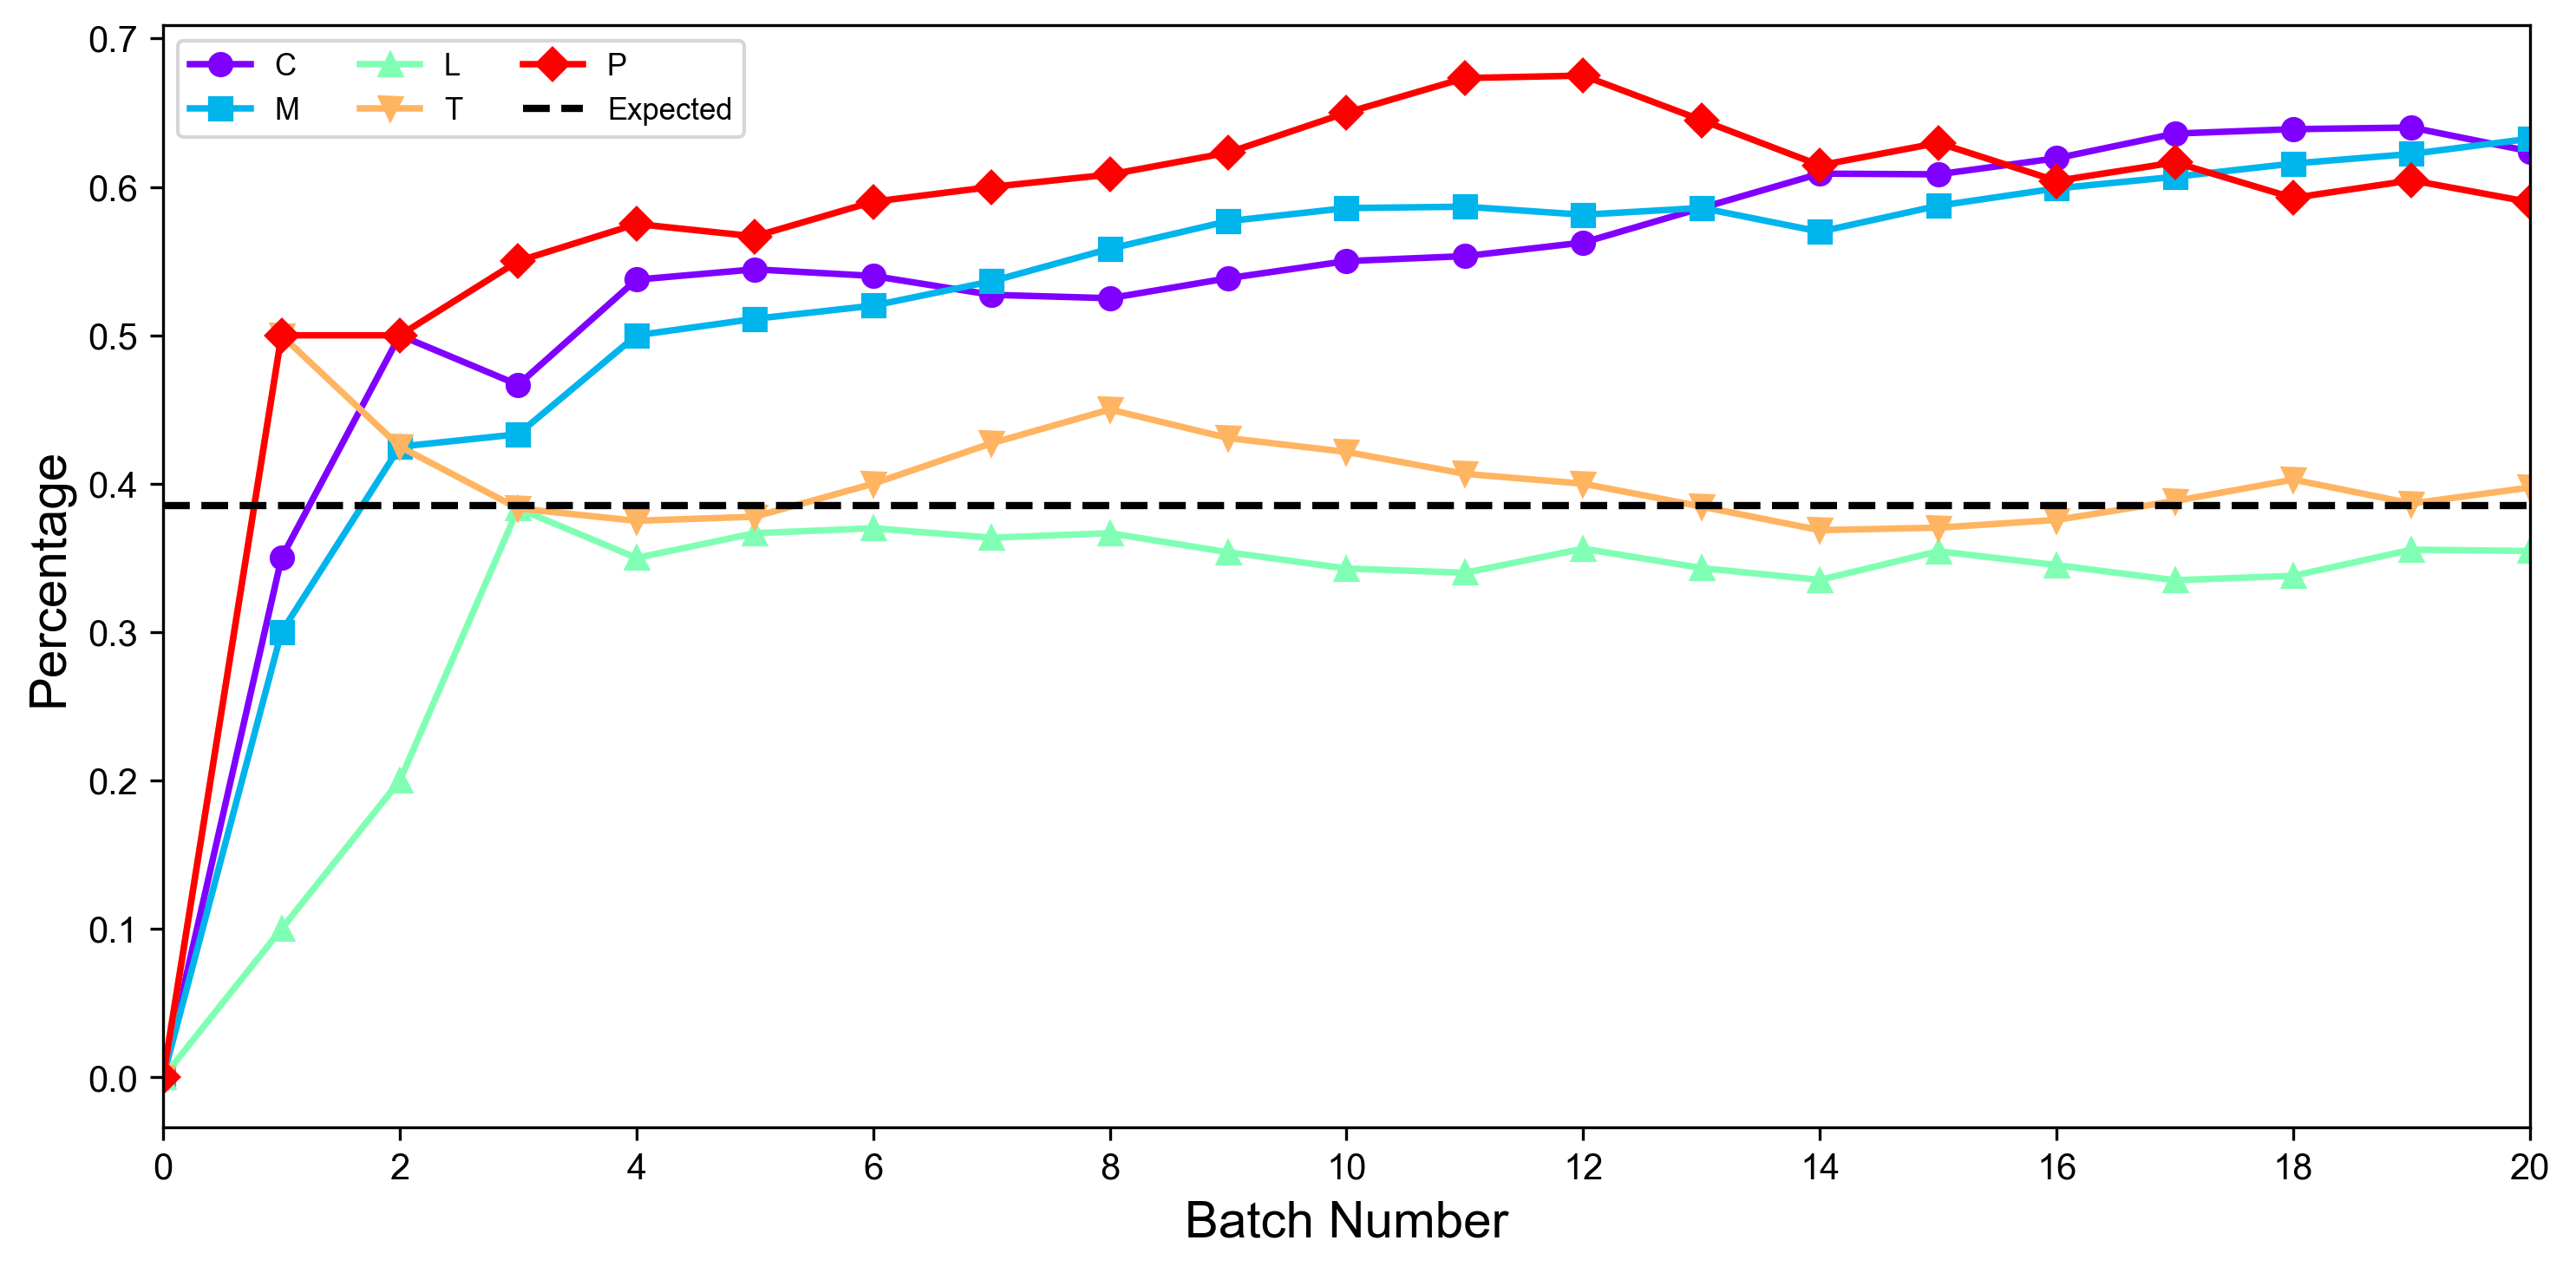

In [20]:
# Now, plot how M and C emerged from the sampling process 

labels = ["C", "M", "L", "T", "P"]
_percentage_all = []

for i in range(1, len(data_all_origin) + 1):
    data_temp = pd.concat(data_all_origin[0:i])
    sequence_temp = np.array([re.search(r'(?:^\d+-)?(?P<seq>(?:[A-Z],?)+)(?:-\d+)?$', text).group("seq").split(',') for text in data_temp["exp"].values])
    
    _percentage_batch = []
    for label_temp in labels:
        _percentage = ((sequence_temp == label_temp).sum(axis=1) > 0).sum() / len(sequence_temp)
        _percentage_batch.append(_percentage)
    _percentage_all.append(_percentage_batch)
_percentage_all = np.array(_percentage_all)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

n_labels    = len(labels)
batch_count = _percentage_all.shape[0]

# Real batches 1…batch_count
x_real = np.arange(1, batch_count + 1)

# Full rainbow palette
cmap = plt.get_cmap('rainbow', n_labels)

plt.figure(figsize=(10, 5), dpi=300)

for idx, label_temp in enumerate(labels):
    y_real = _percentage_all[:, idx]
    # Prepend the (0,0) point
    x_plot = np.concatenate(([0], x_real))
    y_plot = np.concatenate(([0], y_real))
    
    plt.plot(
        x_plot,
        y_plot,
        label=label_temp,
        color=cmap(idx),
        marker=marker_styles[idx % len(marker_styles)],
        linestyle='-',
        linewidth=1.8,
        markersize=6
    )

# Reference line (only for batches ≥1)
plt.axhline(
    y=1 - (18/19)**9,
    color='black',
    linestyle='--',
    linewidth=2,
    label='Expected'
)

# Styling
plt.xlim(0, min(batch_count, 20))
plt.xticks(np.arange(0, min(batch_count, 20) + 1))  # integer ticks from 0…20
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel("Batch Number", fontsize=14)
plt.ylabel("Percentage", fontsize=14)
plt.legend(ncol=3, fontsize='small', loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
sorted_sequences_original[0:24]

array([['M', 'T', 'L', 'M', 'C', 'L', 'M', 'M', 'K', 'M'],
       ['T', 'C', 'M', 'M', 'K', 'T', 'T', 'C', 'M', 'T'],
       ['T', 'T', 'L', 'M', 'L', 'M', 'C', 'M', 'T', 'K'],
       ['G', 'L', 'M', 'K', 'K', 'M', 'M', 'P', 'L', 'M'],
       ['F', 'F', 'F', 'C', 'K', 'C', 'C', 'C', 'C', 'C'],
       ['K', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'S'],
       ['Y', 'M', 'M', 'K', 'M', 'K', 'M', 'M', 'M', 'K'],
       ['C', 'M', 'G', 'L', 'L', 'P', 'K', 'L', 'M', 'P'],
       ['T', 'C', 'T', 'L', 'M', 'T', 'L', 'M', 'M', 'K'],
       ['M', 'T', 'T', 'M', 'K', 'M', 'T', 'M', 'C', 'M'],
       ['M', 'P', 'T', 'M', 'K', 'L', 'G', 'P', 'C', 'S'],
       ['P', 'K', 'K', 'T', 'T', 'K', 'M', 'M', 'M', 'K'],
       ['K', 'S', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'],
       ['T', 'M', 'M', 'C', 'K', 'T', 'P', 'M', 'T', 'P'],
       ['G', 'M', 'M', 'K', 'K', 'C', 'M', 'P', 'M', 'L'],
       ['V', 'V', 'M', 'C', 'K', 'Y', 'P', 'F', 'L', 'I'],
       ['T', 'C', 'T', 'L', 'M', 'T', 'L', 'M', 'M', 'K'

#### Go and check how the position will influence the TON 

In [22]:
from collections import defaultdict
import numpy as np
from scipy.stats import pearsonr

subseq_scores = {}
subseq_counts = defaultdict(int)
L = sorted_sequences_original.shape[1]  # peptide length

# Loop over all peptides
for i in range(L - 2):
    subseq_dict = defaultdict(list)
    
    for j in range(len(sorted_sequences_original)):
        triplet = tuple(sorted_sequences_original[j, i:i+3])
        subseq_dict[triplet].append(j)
        subseq_counts[triplet] += 1

    for triplet, indices in subseq_dict.items():
        mask = np.zeros(len(sorted_tons_original), dtype=bool)
        mask[indices] = True
        if sum(mask) > 1:  # avoid tiny groups
            r, _ = pearsonr(mask.astype(int), sorted_tons_original)
            subseq_scores[triplet] = r

In [23]:
sorted_subseq = sorted(subseq_scores.items(), key=lambda x: abs(x[1]), reverse=True)

In [24]:
for subseq, score in sorted_subseq:
    count = subseq_counts[subseq]
    if count > 8 and abs(score) > 0.10:
        print(f"{''.join(subseq)} (count={count}): correlation = {score:.3f}")

MMM (count=17): correlation = 0.258
MMK (count=11): correlation = 0.245
MCK (count=32): correlation = 0.185
KMM (count=12): correlation = 0.179
TLM (count=11): correlation = 0.165
VMC (count=24): correlation = 0.147
CKS (count=11): correlation = 0.143
CCK (count=12): correlation = 0.126
MCM (count=9): correlation = 0.110
CKC (count=9): correlation = 0.105


In [25]:
sorted_sequences_original

array([['M', 'T', 'L', ..., 'M', 'K', 'M'],
       ['T', 'C', 'M', ..., 'C', 'M', 'T'],
       ['T', 'T', 'L', ..., 'M', 'T', 'K'],
       ...,
       ['Q', 'P', 'Q', ..., 'F', 'P', 'P'],
       ['P', 'E', 'D', ..., 'V', 'T', 'M'],
       ['D', 'E', 'S', ..., 'Y', 'V', 'M']], dtype='<U1')

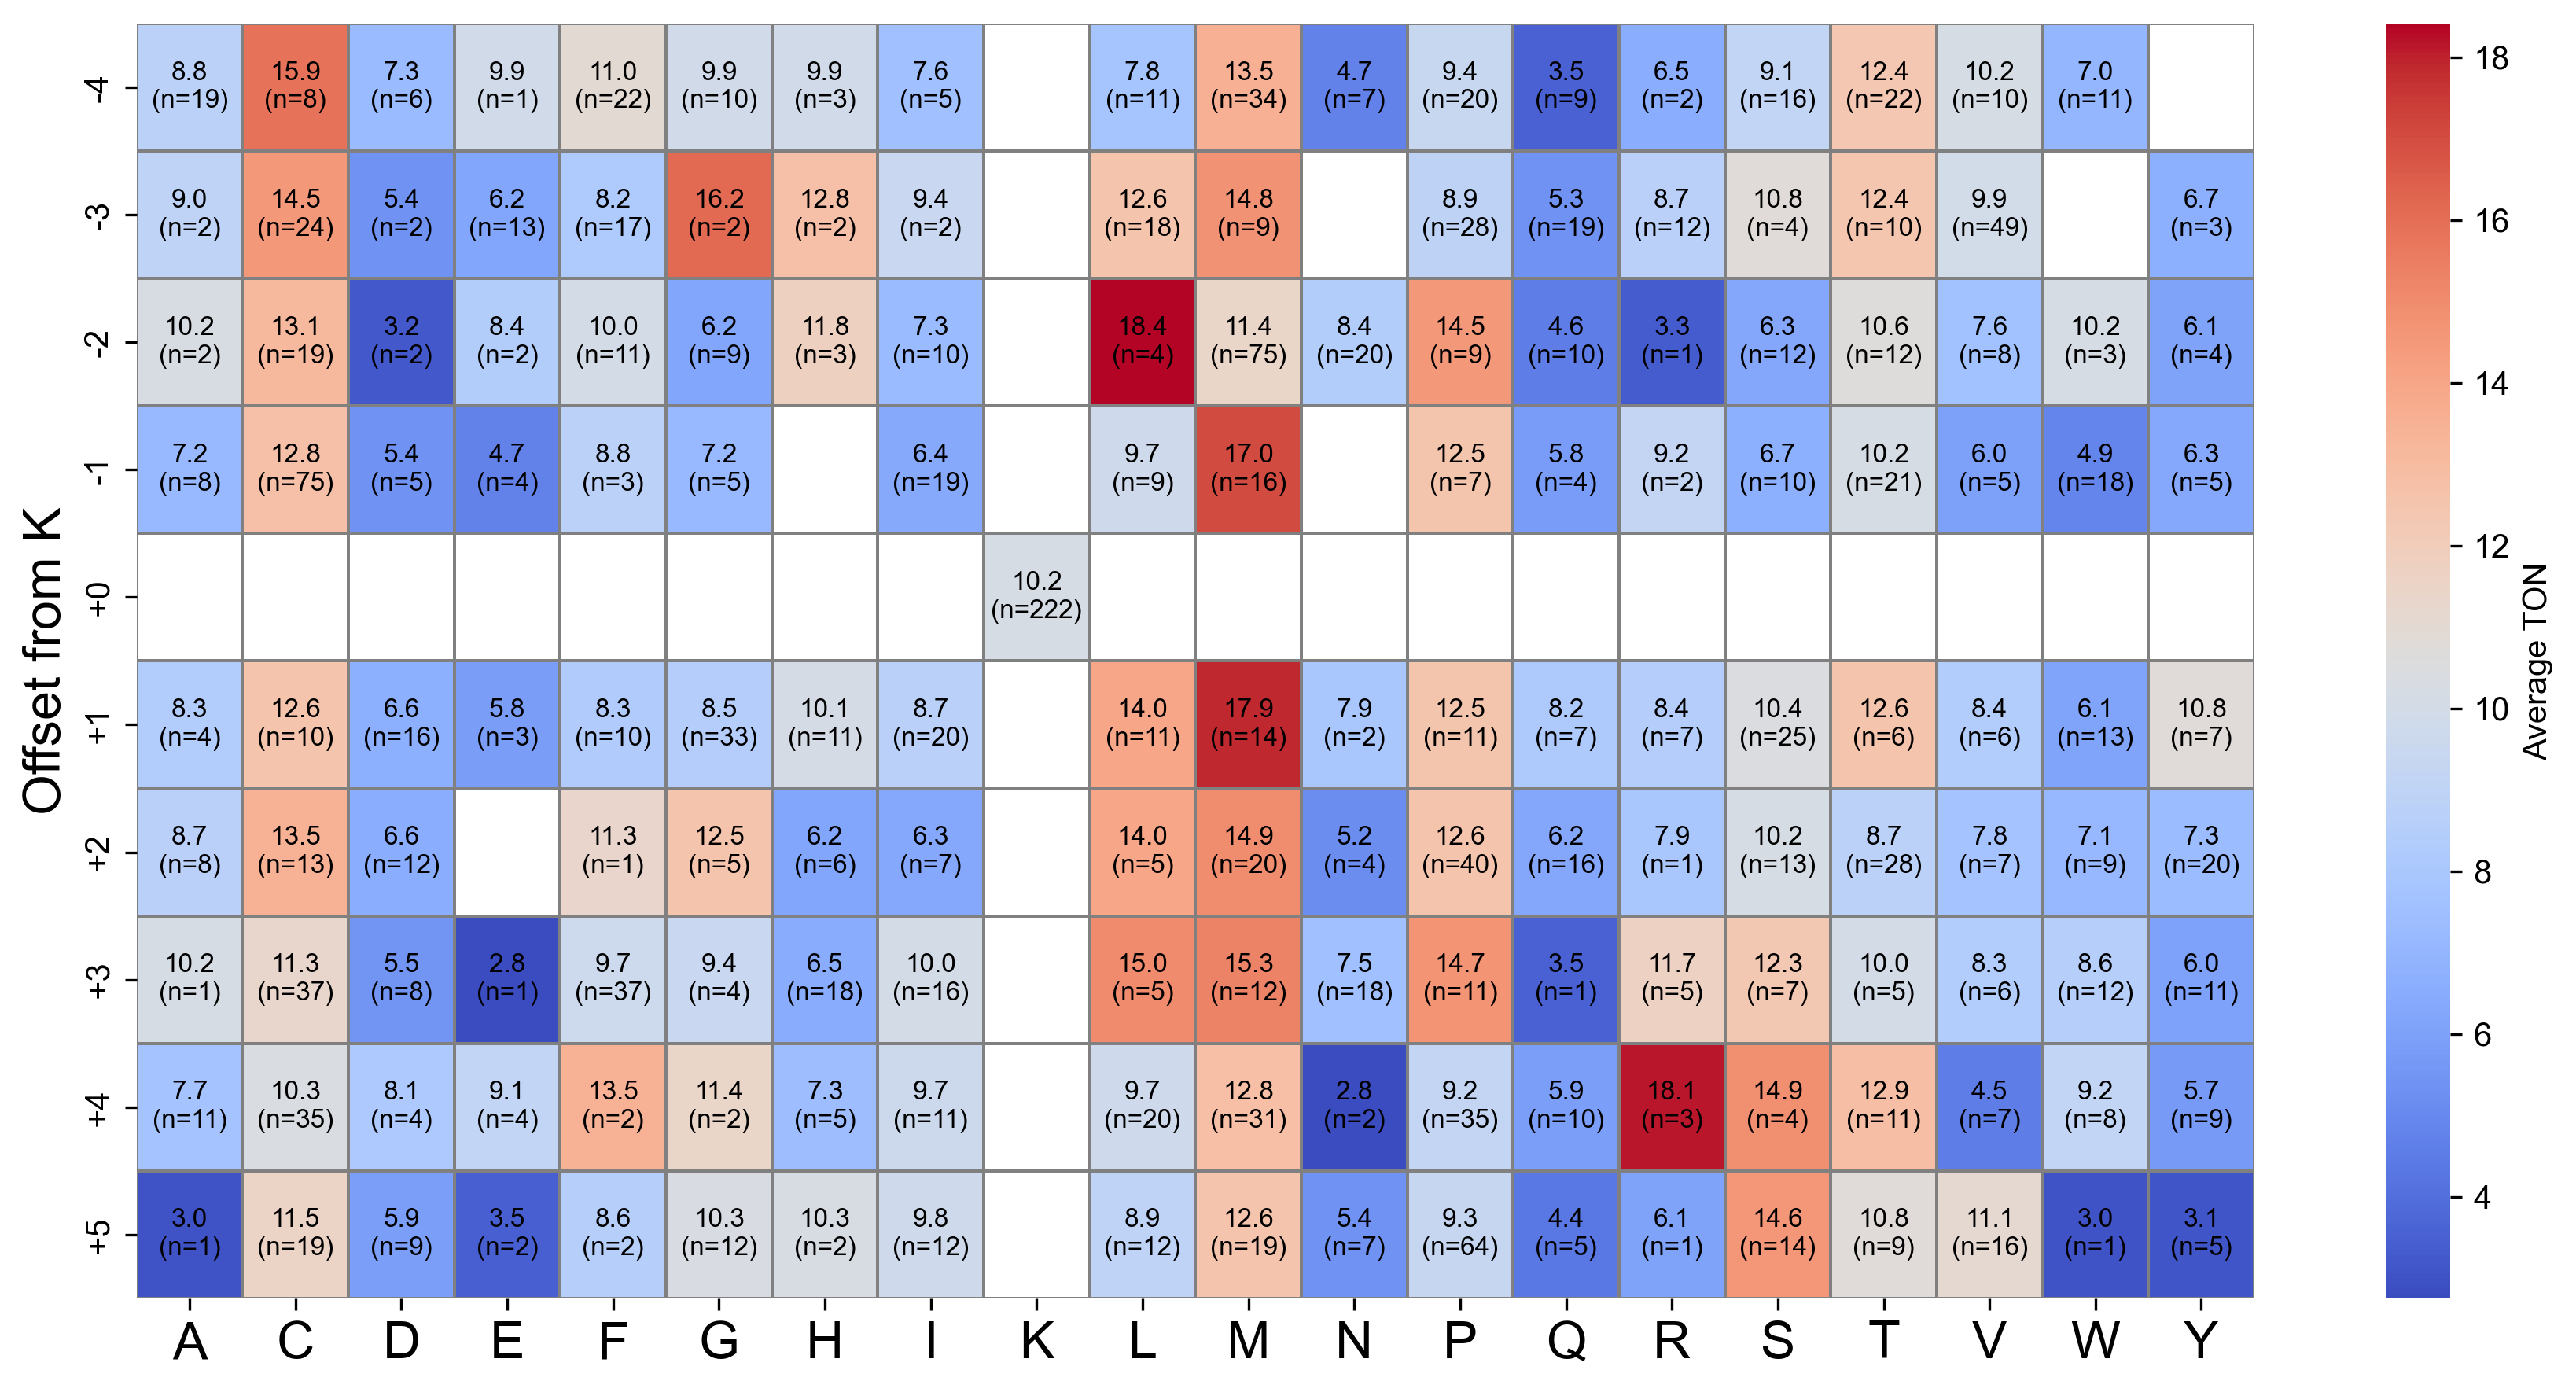

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
#  Build the matrices
# ------------------------------------------------------------------
offset_range = range(-4, 6)                       # -4 … +5 around the Lys (K)
aa_list = sorted(np.unique(sorted_sequences_original))

# 1) bucket TONs by (offset, amino-acid)
heatmap_dict = {(offset, aa): [] for offset in offset_range for aa in aa_list}

for seq, ton in zip(sorted_sequences_original, sorted_tons_original):
    k_idx = [i for i, aa in enumerate(seq) if aa == "K"]    # positions of K
    if len(k_idx) != 1:                                      # skip multi-K sequences
        continue
    k_pos = k_idx[0]
    for offset in offset_range:
        pos = k_pos + offset
        if 0 <= pos < len(seq):
            heatmap_dict[(offset, seq[pos])].append(ton)

# 2) convert to average-TON and counts DataFrames
avg_mat   = pd.DataFrame(index=offset_range, columns=aa_list, dtype=float)
count_mat = pd.DataFrame(index=offset_range, columns=aa_list, dtype=int)

for (offset, aa), tons in heatmap_dict.items():
    avg_mat.at[offset, aa]   = np.mean(tons) if tons else np.nan
    count_mat.at[offset, aa] = len(tons)

# 3) annotation strings (“avg\n(n=…)”)
annot = (avg_mat.round(1).astype(str)
         .where(~avg_mat.isna(), "") +   # blank where no data
         "\n(n=" + count_mat.fillna(0).astype(int).astype(str) + ")").where(~avg_mat.isna(), "")

# ------------------------------------------------------------------
#  Plot: amino-acid on X, offset on Y
# ------------------------------------------------------------------
plt.figure(figsize=(12, 6), dpi=300)

sns.heatmap(
    avg_mat,                      # rows = offset / position  ➔ Y-axis
    cmap="coolwarm",
    center=np.nanmean(sorted_tons_original),
    xticklabels=aa_list,          # amino acids along X
    yticklabels=[f"{o:+d}" for o in offset_range],  # +1, 0, –1, … (formatting)
    linewidths=.5, linecolor="gray",
    cbar_kws={"label": "Average TON"},
    annot=annot, 
    fmt="",          # show avg+count
    annot_kws={"size": 8, "color": "black"}
)
plt.xticks(fontsize=16)

plt.ylabel("Offset from K", fontsize = 16)
plt.tight_layout()
plt.show()

In [27]:
C_number = []
C_tons = []
for seq, ton in zip(sorted_sequences_original, sorted_tons_original):
    _positions = np.where(seq == 'C')[0]  # if your sequences are strings; use ord('K') if integer-encoded
    C_number.append(len(_positions))
    C_tons.append(ton)

C_number = np.array(C_number)
C_tons = np.array(C_tons)

M_number = []
M_tons = []
for seq, ton in zip(sorted_sequences_original, sorted_tons_original):
    _positions = np.where(seq == 'M')[0]  # if your sequences are strings; use ord('K') if integer-encoded
    M_number.append(len(_positions))
    M_tons.append(ton)

M_number = np.array(M_number)
M_tons = np.array(M_tons)

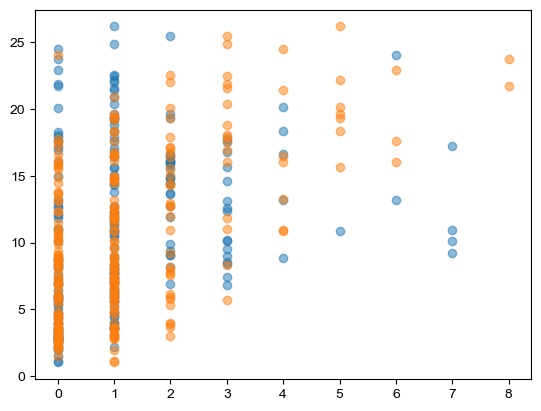

In [28]:
plt.scatter(C_number, C_tons, alpha = 0.5, linewidths = 1)
plt.scatter(M_number, M_tons, alpha = 0.5, linewidths = 1)

In [29]:
_number = []
_tons = []
_seq = []
for seq, ton in zip(sorted_sequences_original, sorted_tons_original):
    _positions = np.where(((seq == 'M') + (seq == "C"))>0)[0]  # if your sequences are strings; use ord('K') if integer-encoded
    _number.append(len(_positions))
    _tons.append(ton)
    _seq.append(seq)

_number = np.array(_number)
_tons = np.array(_tons)
_seq = np.array(_seq)

(0.0, 10.0)

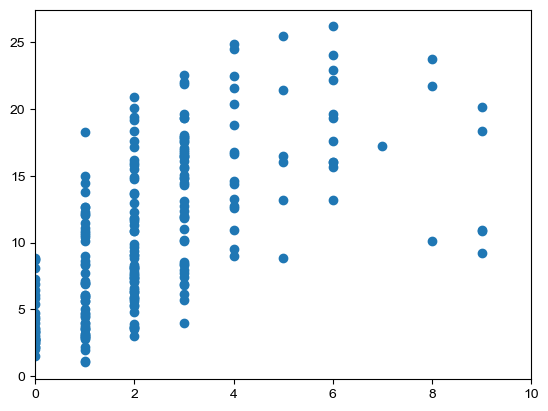

In [30]:
plt.scatter(_number, _tons)
plt.xlim(0,10)

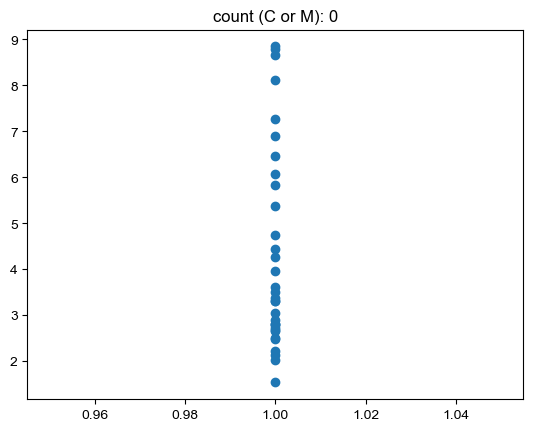

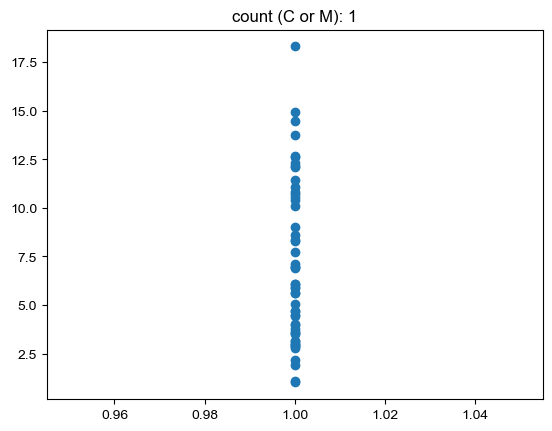

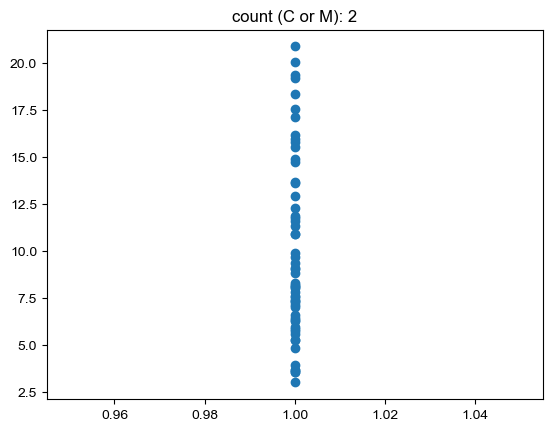

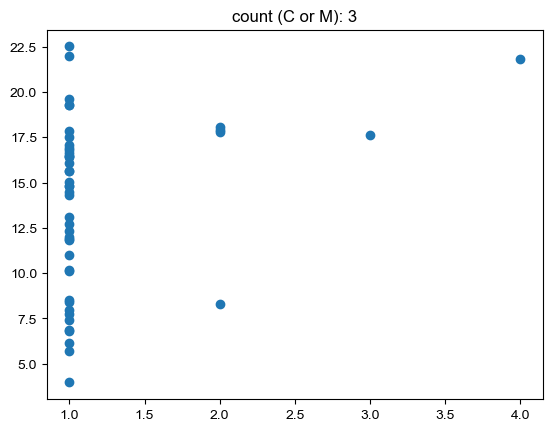

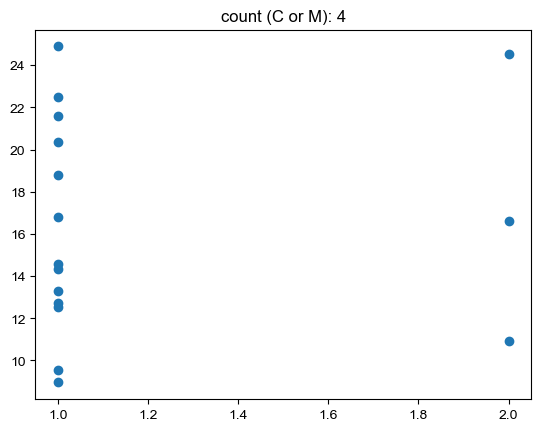

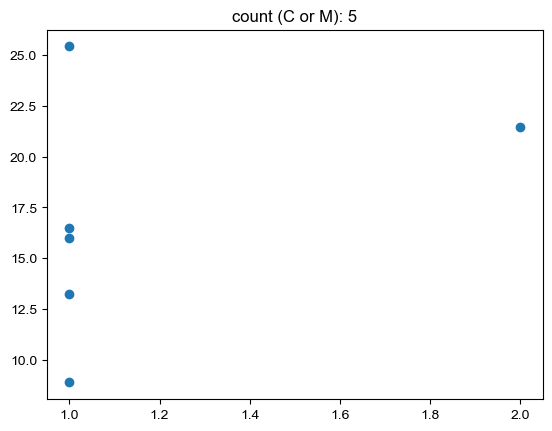

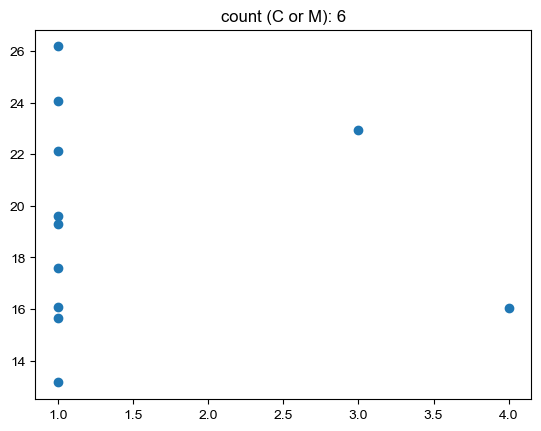

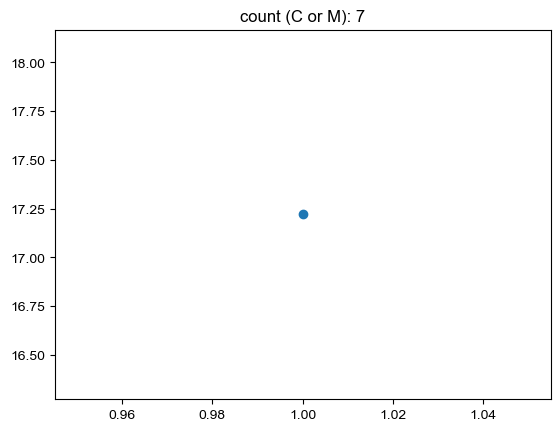

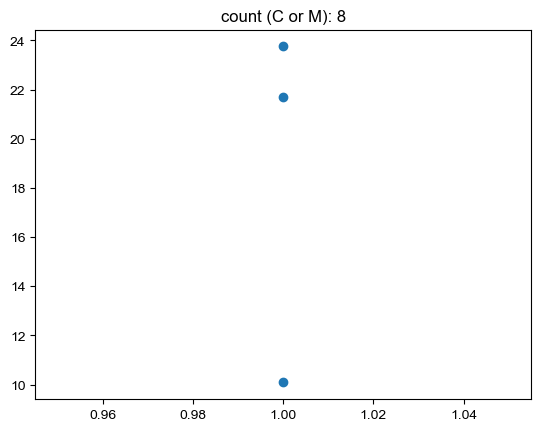

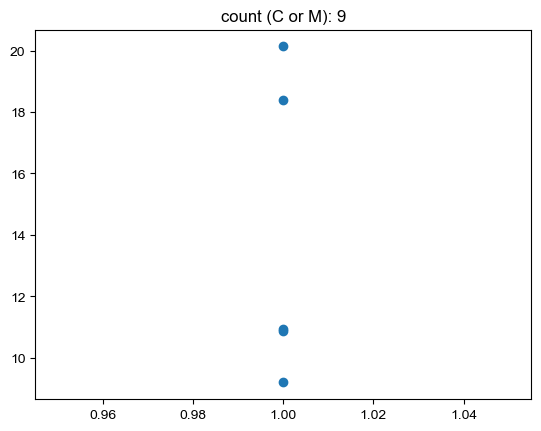

In [31]:
for selected_number in range(10):
    plt.title(f"count (C or M): {selected_number}")
    plt.scatter(
        (_seq[_number == selected_number] == "K").sum(axis = 1),
        _tons[_number == selected_number])
    plt.show()